## Classification Model with Linear Model

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [3]:
import parse_inputs

from pathlib import Path

import numpy as np
import pandas as pd
from pandas_plink import read_plink

from sklearn import linear_model
from sklearn.svm import SVR

from ggplot import *
PATH=Path('ddat/crowdAI/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Build Model

## Data Prepare

In [4]:
!ls {TMP_PATH}

all_bed_T.pk	       all_bim_top10000.pk  os_meta_test.csv
all_bed_T_top10000.pk  all_fam.pk	    os_sub_test_bed_top10000.pk
all_bim.pk	       all_fam_top10000.pk  tz_and_os_meta.csv


In [5]:
all_bed_T = pd.read_pickle(TMP_PATH/'all_bed_T_top10000.pk')
os_sub_test_align =pd.read_pickle(TMP_PATH/'os_sub_test_bed_top10000.pk')

In [318]:
all_meta = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)
os_meta_test = pd.read_csv(TMP_PATH/'os_meta_test.csv',index_col=0)

In [24]:
all_bim = pd.read_pickle(TMP_PATH/'all_bim_top10000.pk')
snps = pd.read_csv(PATH/'snps_sorted_p_val_v2.csv')
common_index = [i for i,x in enumerate(snps.snp[0:10000]) if x in set(all_bim.snp)]
common_snp_byp=snps.snp[0:10000][common_index]
all_bim_idx=[np.where(x==all_bim.snp)[0][0] for x in common_snp_byp]

In [315]:
snps.head(10000)

chr_x         snp  none      pos_x a1 a2             POS  MarkerName  \
0         3    rs724016     0  141105570  G  A  chr3:141105570    rs724016   
1         3   rs6764769     0  141100280  G  A  chr3:141100280   rs6764769   
2         3   rs6763931     0  141102833  A  G  chr3:141102833   rs6763931   
3         3   rs6440003     0  141094209  A  G  chr3:141094209   rs6440003   
4         3   rs2871960     0  141121814  C  A  chr3:141121814   rs2871960   
5         3   rs9846396     0  141140968  T  C  chr3:141140968   rs9846396   
6         3   rs7624084     0  141093285  C  T  chr3:141093285   rs7624084   
7        20   rs4911178     0   33952620  G  A  chr20:33952620   rs4911178   
8        20   rs6087704     0   34001058  C  T  chr20:34001058   rs6087704   
9        20   rs6088813     0   33975181  C  A  chr20:33975181   rs6088813   
10       20   rs6060371     0   33913322  T  G  chr20:33913322   rs6060371   
11       20   rs6060373     0   33914208  G  A  chr20:33914208   rs6060373   
12       20   rs4911494     0   33971914  C  T  chr20:33971914   rs4911494   
13       20   rs6088791     0   33907909  C  T  chr20:33907909   rs6088791   
14       20   rs1406948     0   33905619  A  G  chr20:33905619   rs1406948   
15       20    rs878639     0   33894463  G  A  chr20:33894463    rs878639   
16        3   rs7613516     0  141079309  G  T  chr3:141079309   rs7613516   
17       20   rs6060355     0   33890061  A  G  chr20:33890061   rs6060355   
18        3   rs1346408     0  141072289  T  C  chr3:141072289   rs1346408   
19        3   rs6784404     0  141073675  A  G  chr3:141073675   rs6784404   
20       12      rs8756     0   66359752  C  A  chr12:66359752      rs8756   
21        7     rs42039     0   92244422  T  C   chr7:92244422     rs42039   
22       12   rs1042725     0   66358347  C  T  chr12:66358347   rs1042725   
23        7      rs8179     0   92236164  T  C   chr7:92236164      rs8179   
24        7   rs2282978     0   92264410  C  T   chr7:92264410   rs2282978   
25       12   rs1351394     0   66351826  T  C  chr12:66351826   rs1351394   
26        4   rs1812175     0  145574844  A  G  chr4:145574844   rs1812175   
27        7      rs4272     0   92236829  G  A   chr7:92236829      rs4272   
28        4   rs7689420     0  145568352  T  C  chr4:145568352   rs7689420   
29        7   rs2282979     0   92264993  C  T   chr7:92264993   rs2282979   
...     ...         ...   ...        ... .. ..             ...         ...   
9970     10   rs7913974     0   89335977  T  C  chr10:89335977   rs7913974   
9971     16   rs1544800     0     985947  A  G    chr16:985947   rs1544800   
9972      5    rs154081     0  111028566  G  A  chr5:111028566    rs154081   
9973     17   rs2854704     0   76175824  C  A  chr17:76175824   rs2854704   
9974     17   rs9910135     0   41823402  T  C  chr17:41823402   rs9910135   
9975      1    rs946205     0  119448317  G  T  chr1:119448317    rs946205   
9976     13   rs4598779     0   40235373  C  T  chr13:40235373   rs4598779   
9977      1   rs2232816     0  171753039  A  G  chr1:171753039   rs2232816   
9978      6   rs1264423     0   30571471  T  C   chr6:30571471   rs1264423   
9979      1  rs12039471     0   65134704  T  G   chr1:65134704  rs12039471   
9980      5    rs316738     0   41645551  C  T   chr5:41645551    rs316738   
9981      5    rs889023     0  171762100  C  A  chr5:171762100    rs889023   
9982      2   rs9973704     0   37999909  G  A   chr2:37999909   rs9973704   
9983      8   rs6980834     0   24138128  T  C   chr8:24138128   rs6980834   
9984     17  rs11079563     0   63311922  A  G  chr17:63311922  rs11079563   
9985      6    rs162984     0  155632938  T  C  chr6:155632938    rs162984   
9986      1   rs3790609     0  113056990  T  C  chr1:113056990   rs3790609   
9987      5  rs11954856     0  112087327  T  G  chr5:112087327  rs11954856   
9988      6   rs2517455     0   31059900  C  T   chr6:31059900   rs2517455   
9989      6   rs2621376     

In [377]:
X_geno = all_bed_T
X_geno = X_geno.iloc[:,all_bim_idx]
X_geno.columns = list(common_snp_byp)
X_geno.fillna(-1,inplace=True)
X_meta = pd.DataFrame({'gender':list(all_meta.gender),
                       'nationality':list((all_meta.nationality=='PROBLEM').astype(np.int))},index=X_geno.index)
y = all_meta.height

Xt_geno = os_sub_test_align.T
Xt_geno = Xt_geno.iloc[:,all_bim_idx]
Xt_geno.columns = list(common_snp_byp)
#Replace nan values in the training and testing set with an arbitrary number (-1)
Xt_geno.fillna(-1,inplace=True)
Xt_meta = pd.DataFrame({'gender':pd.Series(list(os_meta_test.SNPSEX),index=Xt_geno.index),
                            'nationality':1})

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [378]:
X = all_bed_T
X = X.iloc[:,all_bim_idx]
X.columns = common_snp_byp
X['gender']=pd.Series(list(all_meta.gender),index=X.index)
X['nationality']=pd.Series(list((all_meta.nationality=='PROBLEM').astype(np.int)),index=X.index)
X.fillna(-1,inplace=True)

y = all_meta.height

df_test = os_sub_test_align.T
df_test = df_test.iloc[:,all_bim_idx]
df_test.columns = common_snp_byp
df_test['gender']=pd.Series(list(os_meta_test.SNPSEX),index=df_test.index)
df_test['nationality']=1
#Replace nan values in the training and testing set with an arbitrary number (-1)
df_test.fillna(-1,inplace=True)

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


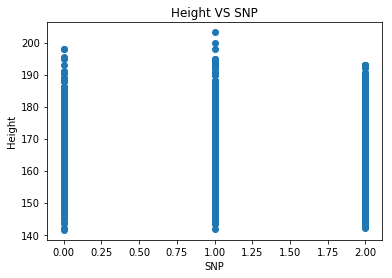

In [324]:
plt.scatter(X.iloc[:,0], y);
plt.title('Height VS SNP');
plt.xlabel('SNP');
plt.ylabel('Height');

In [326]:
all_meta.head()

ID  height           ChipID.1 nationality  gender
ChipID                                                                  
9992564090_R01C01  TL2257   177.0  9992564090_R01C01         HAN       1
9992564090_R05C01  TL0067   155.0  9992564090_R05C01         HAN       2
9992564090_R07C01  TL0139   143.5  9992564090_R07C01         HAN       2
9992564090_R08C01  TL0279   161.9  9992564090_R08C01         HAN       2
9992564137_R01C01  TL1090   155.2  9992564137_R01C01         HAN       2

In [327]:
def y_boolean(x,m,f,g):
    if g==1:
        return int(x>m)
    elif g==2:
        return int(x>f)
    else:
        print('error')

m50 = np.percentile(y.loc[list(X.gender==1)],50)
f50 = np.percentile(y.loc[list(X.gender==2)],50)
yb= [y_boolean(x,m50,f50,X.gender.iloc[i]) for i,x in enumerate(y)]

In [328]:
sum(yb)

1763

In [329]:
def y_triple(x,mh,ml,fh,fl,g):
    if g==1:
        if x>mh:
            return 1
        elif x<ml:
            return -1
        else:
            return 0
    elif g==2:
        if x>fh:
            return 1
        elif x<fl:
            return -1
        else:
            return 0
    else:
        print('error')

m25 = np.percentile(y.loc[list(X.gender==1)],25)
f25 = np.percentile(y.loc[list(X.gender==2)],25)
m75 = np.percentile(y.loc[list(X.gender==1)],75)
f75 = np.percentile(y.loc[list(X.gender==2)],75)
print(m25,f25,m75,f75)
yt= [y_triple(x,m75,m25,f75,f25,X.gender.iloc[i]) for i,x in enumerate(y)]

165.2 153.9 177.0 162.0


In [330]:
pd.Series(yt).value_counts()

 0    1802
-1     874
 1     854
dtype: int64

# 1. ALL Data 

## 1.1 Linear Model

In [23]:
from sklearn import linear_model
import crowdai

### 1.1.1 Linear Model with ALL data by top 10000, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10 snps

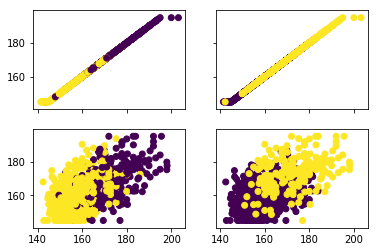

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 7c21ed4f-a649-4742-b213-ffd6b4788198


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 7c21ed4f-a649-4742-b213-ffd6b4788198


100% |██████████|[00:00<00:00]  108.37% /s] 


CrowdAI.Event.Job.INFO : (7c21ed4f-a649-4742-b213-ffd6b4788198) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.207875754911 ; MSE : 122.786588796
CrowdAI.Event.Job.COMPLETE : 7c21ed4f-a649-4742-b213-ffd6b4788198	   🍺 


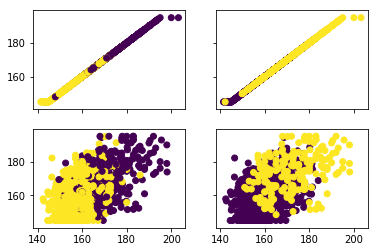

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : f4775040-7c95-4bcf-84d5-55d402e5c5c7


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : f4775040-7c95-4bcf-84d5-55d402e5c5c7


100% |██████████|[00:00<00:00]  106.94% /s] 


CrowdAI.Event.Job.INFO : (f4775040-7c95-4bcf-84d5-55d402e5c5c7) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.454412387517 ; MSE : 147.848265883
CrowdAI.Event.Job.COMPLETE : f4775040-7c95-4bcf-84d5-55d402e5c5c7	   🍺 


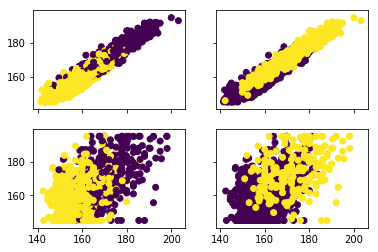

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 85ff05f3-5740-4d41-8c84-f3dd7106d1ce


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 85ff05f3-5740-4d41-8c84-f3dd7106d1ce


100% |██████████|[00:00<00:00]  107.80% /s] 


CrowdAI.Event.Job.INFO : (85ff05f3-5740-4d41-8c84-f3dd7106d1ce) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.752164365613 ; MSE : 178.116238022
CrowdAI.Event.Job.COMPLETE : 85ff05f3-5740-4d41-8c84-f3dd7106d1ce	   🍺 


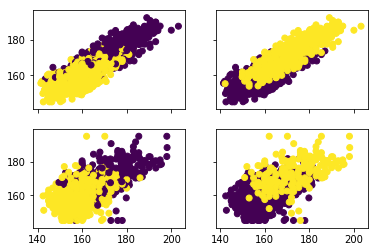

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 5092872a-1a44-43c2-8a56-380e6112f3e9


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 5092872a-1a44-43c2-8a56-380e6112f3e9


100% |██████████|[00:00<00:00]  105.86% /s] 


CrowdAI.Event.Job.INFO : (5092872a-1a44-43c2-8a56-380e6112f3e9) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.0158434020208 ; MSE : 103.265543312
CrowdAI.Event.Job.COMPLETE : 5092872a-1a44-43c2-8a56-380e6112f3e9	   🍺 


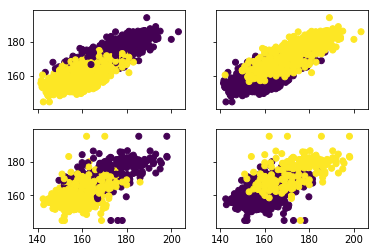

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3000b644-cf0a-4927-8682-a3971153acba


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3000b644-cf0a-4927-8682-a3971153acba


100% |██████████|[00:00<00:00]  107.66% /s] 


CrowdAI.Event.Job.INFO : (3000b644-cf0a-4927-8682-a3971153acba) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.153609099171 ; MSE : 86.0398522596
CrowdAI.Event.Job.COMPLETE : 3000b644-cf0a-4927-8682-a3971153acba	   🍺 


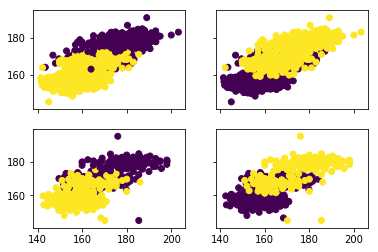

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 21607d73-6b9d-4ced-b396-fe41e3e3e9f2


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 21607d73-6b9d-4ced-b396-fe41e3e3e9f2


100% |██████████|[00:00<00:00]  109.30% /s] 


CrowdAI.Event.Job.INFO : (21607d73-6b9d-4ced-b396-fe41e3e3e9f2) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.352452757549 ; MSE : 65.8264036358
CrowdAI.Event.Job.COMPLETE : 21607d73-6b9d-4ced-b396-fe41e3e3e9f2	   🍺 


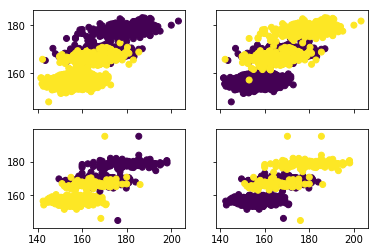

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 4fb230f1-2c25-49b3-9678-9e8f4a3a225a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 4fb230f1-2c25-49b3-9678-9e8f4a3a225a


100% |██████████|[00:00<00:00]  105.83% /s] 


CrowdAI.Event.Job.INFO : (4fb230f1-2c25-49b3-9678-9e8f4a3a225a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.414332120865 ; MSE : 59.5360580373
CrowdAI.Event.Job.COMPLETE : 4fb230f1-2c25-49b3-9678-9e8f4a3a225a	   🍺 


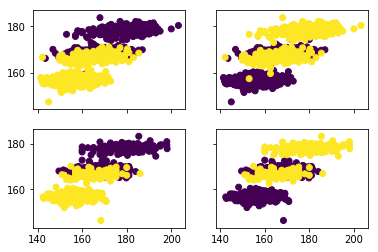

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 1a31c31b-de73-480e-9f79-171955de35d1


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 1a31c31b-de73-480e-9f79-171955de35d1


100% |██████████|[00:00<00:00]  107.08% /s] 


CrowdAI.Event.Job.INFO : (1a31c31b-de73-480e-9f79-171955de35d1) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.405394181403 ; MSE : 60.4446441174
CrowdAI.Event.Job.COMPLETE : 1a31c31b-de73-480e-9f79-171955de35d1	   🍺 


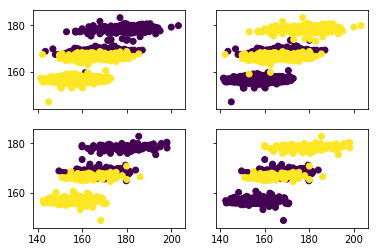

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3a0ab72c-76f4-4fe0-a2d6-6016c1a28d24


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3a0ab72c-76f4-4fe0-a2d6-6016c1a28d24


100% |██████████|[00:00<00:00]  109.22% /s] 


CrowdAI.Event.Job.INFO : (3a0ab72c-76f4-4fe0-a2d6-6016c1a28d24) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.401972990704 ; MSE : 60.7924251982
CrowdAI.Event.Job.COMPLETE : 3a0ab72c-76f4-4fe0-a2d6-6016c1a28d24	   🍺 


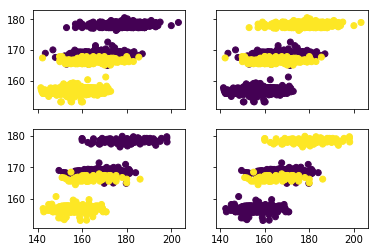

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 5d3e2c19-0a36-4b11-b90e-812c70d70e55


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 5d3e2c19-0a36-4b11-b90e-812c70d70e55


100% |██████████|[00:00<00:00]  105.34% /s] 


CrowdAI.Event.Job.INFO : (5d3e2c19-0a36-4b11-b90e-812c70d70e55) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.414700788309 ; MSE : 59.4985811547
CrowdAI.Event.Job.COMPLETE : 5d3e2c19-0a36-4b11-b90e-812c70d70e55	   🍺 


In [331]:
score_list={}
submit={}
for n in [7726, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10]:
    var_idx = list(range(n))+list([7726,7727])
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.iloc[:,var_idx].values, np.array(y))
    x_test = df_test.iloc[:,var_idx].values
    # Instantiate a linear model
    regr = linear_model.LinearRegression()
    regr.fit(trn, y_trn)
    

    preds = np.clip(regr.predict(trn),145,195)
    preds1 = np.clip(regr.predict(val),145,195)

    score_list[n]=(regr.score(trn, y_trn), regr.score(val, y_val))

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    ax1.scatter(y_trn,preds,c=trn[:,-2], marker='o')
    ax2.scatter(y_trn,preds,c=trn[:,-1], marker='o')
    ax3.scatter(y_val,preds1,c=val[:,-2], marker='o')
    ax4.scatter(y_val,preds1,c=val[:,-1], marker='o')
    plt.show()

    heights = np.clip(regr.predict(x_test),145,195).tolist()
    # Create the challenge object by authentication with crowdAI with your API_KEY
    challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
    submit[n]=challenge.submit(heights)
    challenge.disconnect()


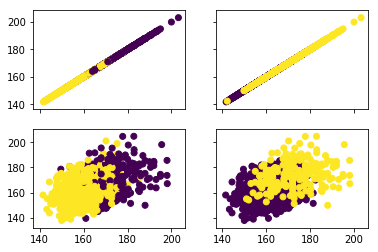

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[1:07:33<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 07410f69-f174-4620-9ece-c1a2331a5168


          
  0% |          |[1:07:33<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 07410f69-f174-4620-9ece-c1a2331a5168


          
  0% |          |[1:07:34<?]  ?% /s] 
  0% |          |[00:01<?]  ?% /s] 
          ██████|[00:01<00:00]  79.71% /s] 
  0% |          |[1:07:34<?]  ?% /s] 
100% |██████████|[00:01<00:00]  79.71% /s] 


CrowdAI.Event.Job.INFO : (07410f69-f174-4620-9ece-c1a2331a5168) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.470801610941 ; MSE : 149.514312104
CrowdAI.Event.Job.COMPLETE : 07410f69-f174-4620-9ece-c1a2331a5168	   🍺 


In [115]:
score_list={}
submit={}
#var_idx = list(range(n))+list([7726,7727])
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y))
x_test = df_test.values
# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(trn, y_trn)
preds = regr.predict(trn)
preds1 = regr.predict(val)

score_list[1]=(regr.score(trn, y_trn), regr.score(val, y_val))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.scatter(y_trn,preds,c=trn[:,-2], marker='o')
ax2.scatter(y_trn,preds,c=trn[:,-1], marker='o')
ax3.scatter(y_val,preds1,c=val[:,-2], marker='o')
ax4.scatter(y_val,preds1,c=val[:,-1], marker='o')
plt.show()

heights = regr.predict(x_test).tolist()
# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
submit[1]=challenge.submit(heights)
challenge.disconnect()


### 1.1.2 Linear Model with ALL data by top 10000, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10 snps (PCA)

In [309]:
def topsnp_model_pca(m,X,y,df_test,val_idx,residual=False,topn=[7726, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10]):
    score_list={}
    submit={}
    for n in topn:
        if residual:
            var_idx = list(range(n))
            ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.iloc[:,var_idx].values, np.array(y))
            x_test = df_test.iloc[:,var_idx].values
            gn_idx = list([7726,7727])
            ((val_gn,trn_gn), (y_val_gn,y_trn_gn)) = split_by_idx(val_idx, X.iloc[:,gn_idx].values, np.array(y))
            x_test_gn = df_test.iloc[:,gn_idx].values
        else:
            var_idx = list(range(n))+list([7726,7727])
            ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.iloc[:,var_idx].values, np.array(y))
            x_test = df_test.iloc[:,var_idx].values

        ml = m
        ml.fit(trn, y_trn)
        
        if residual:
            preds = np.clip(ml.predict(trn),-20,20)
            preds1 = np.clip(ml.predict(val),-20,20)
            f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
            ax1.scatter(y_trn,preds,c=trn_gn[:,-2], marker='o')
            ax2.scatter(y_trn,preds,c=trn_gn[:,-1], marker='o')
            ax3.scatter(y_val,preds1,c=val_gn[:,-2], marker='o')
            ax4.scatter(y_val,preds1,c=val_gn[:,-1], marker='o')
            plt.show()
            base=gender_nation_ml.intercept_+np.dot(x_test_gn,gender_nation_ml.coef_)
            heights = (base+np.clip(ml.predict(x_test),-20,20)).tolist()
        else:
            preds = np.clip(ml.predict(trn),145,195)
            preds1 = np.clip(ml.predict(val),145,195)
            f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
            ax1.scatter(y_trn,preds,c=trn[:,-2], marker='o')
            ax2.scatter(y_trn,preds,c=trn[:,-1], marker='o')
            ax3.scatter(y_val,preds1,c=val[:,-2], marker='o')
            ax4.scatter(y_val,preds1,c=val[:,-1], marker='o')
            plt.show()
            heights = np.clip(ml.predict(x_test),145,195).tolist()
        
        score_list[n]=(ml.score(trn, y_trn), ml.score(val, y_val))
        # Create the challenge object by authentication with crowdAI with your API_KEY
        challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
        submit[n]=challenge.submit(heights)
        challenge.disconnect()
    return (score_list,submit)

In [247]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X)
# Apply transform to both the training set and the test set.
train_img = scaler.transform(X)
test_img = scaler.transform(df_test)

In [248]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)
train_img=pca.fit_transform(train_img)

In [249]:
#train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

In [250]:
test_img.shape

(137, 1855)

In [ ]:
lm_all_pca = topsnp_model(m=LogisticRegression(),X=train_img,y=y,df_test=test_img,val_idx=val_idx,
                          topn=[1855, 1000, 500, 200, 100, 50, 20, 10])

### 1.1.3 Logistic 

In [310]:
from sklearn.linear_model import LogisticRegression

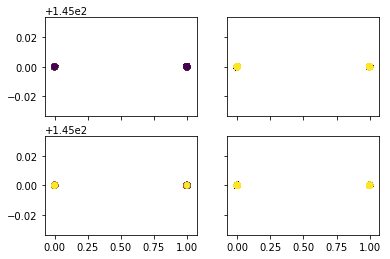

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[24:03:27<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 266f97c1-2eb9-4b87-8b40-158d5c83b7bc



          
  0% |          |[24:03:27<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 266f97c1-2eb9-4b87-8b40-158d5c83b7bc



          
  0% |          |[24:03:27<?]  ?% /s] 
100% |██████████|[00:00<00:00]  100.46% /s] 
          
  0% |          |[24:03:27<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (266f97c1-2eb9-4b87-8b40-158d5c83b7bc) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -8.05469054583 ; MSE : 920.454409489
CrowdAI.Event.Job.COMPLETE : 266f97c1-2eb9-4b87-8b40-158d5c83b7bc	   🍺 


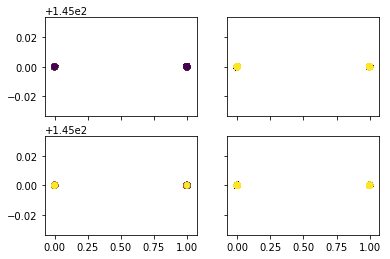

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[24:03:33<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bb41b800-87c3-4a0a-9a0e-49271a4e721f



          
  0% |          |[24:03:34<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bb41b800-87c3-4a0a-9a0e-49271a4e721f



          
  0% |          |[24:03:34<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.61% /s] 
          
  0% |          |[24:03:34<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (bb41b800-87c3-4a0a-9a0e-49271a4e721f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -8.05469054583 ; MSE : 920.454409489
CrowdAI.Event.Job.COMPLETE : bb41b800-87c3-4a0a-9a0e-49271a4e721f	   🍺 


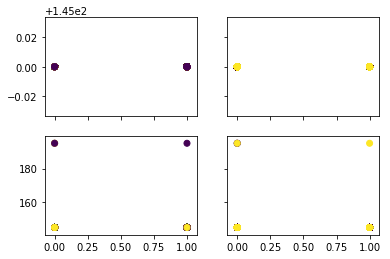

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[24:03:39<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 32919f21-8cb6-45bb-b1dc-83cf0d585cf3



          
  0% |          |[24:03:39<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 32919f21-8cb6-45bb-b1dc-83cf0d585cf3



          
  0% |          |[24:03:39<?]  ?% /s] 
100% |██████████|[00:01<00:00]  93.22% /s] 
          
  0% |          |[24:03:39<?]  ?% /s]  /s] 


CrowdAI.Event.Job.INFO : (32919f21-8cb6-45bb-b1dc-83cf0d585cf3) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -8.05469054583 ; MSE : 920.454409489
CrowdAI.Event.Job.COMPLETE : 32919f21-8cb6-45bb-b1dc-83cf0d585cf3	   🍺 


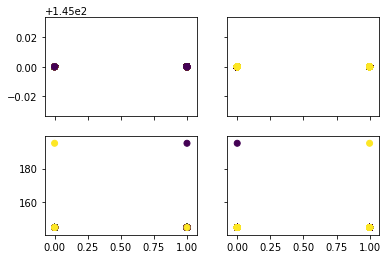

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[24:03:43<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 6105228f-5ad8-4bf9-a0e5-1ba01ba00ccd



          
  0% |          |[24:03:43<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 6105228f-5ad8-4bf9-a0e5-1ba01ba00ccd



          
  0% |          |[24:03:44<?]  ?% /s] 
100% |██████████|[00:01<00:00]  84.13% /s] 
          
  0% |          |[24:03:44<?]  ?% /s]  /s] 


CrowdAI.Event.Job.INFO : (6105228f-5ad8-4bf9-a0e5-1ba01ba00ccd) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -8.05469054583 ; MSE : 920.454409489
CrowdAI.Event.Job.COMPLETE : 6105228f-5ad8-4bf9-a0e5-1ba01ba00ccd	   🍺 


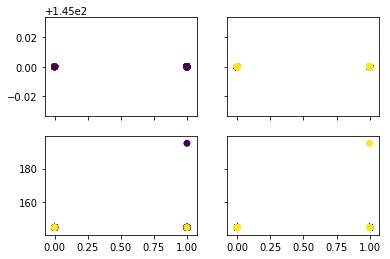

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[24:03:47<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d90f2f14-0b96-4dda-9311-d79faedd0d21


          
  0% |          |[24:03:48<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d90f2f14-0b96-4dda-9311-d79faedd0d21


          
  0% |          |[24:03:48<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  105.27% /s] 
  0% |          |[24:03:48<?]  ?% /s] 
100% |██████████|[00:00<00:00]  105.27% /s] 


CrowdAI.Event.Job.INFO : (d90f2f14-0b96-4dda-9311-d79faedd0d21) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -8.05469054583 ; MSE : 920.454409489
CrowdAI.Event.Job.COMPLETE : d90f2f14-0b96-4dda-9311-d79faedd0d21	   🍺 


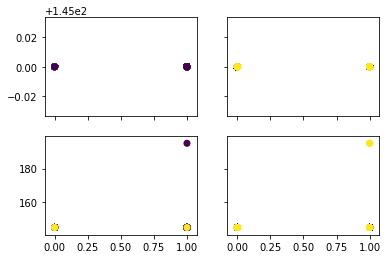

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[24:03:51<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 1939cc9d-20b6-432e-9f7a-4edcd550933c


          
  0% |          |[24:03:52<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 1939cc9d-20b6-432e-9f7a-4edcd550933c


          
  0% |          |[24:03:52<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  104.92% /s] 
  0% |          |[24:03:52<?]  ?% /s] 
100% |██████████|[00:00<00:00]  104.92% /s] 


CrowdAI.Event.Job.INFO : (1939cc9d-20b6-432e-9f7a-4edcd550933c) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -8.05469054583 ; MSE : 920.454409489
CrowdAI.Event.Job.COMPLETE : 1939cc9d-20b6-432e-9f7a-4edcd550933c	   🍺 


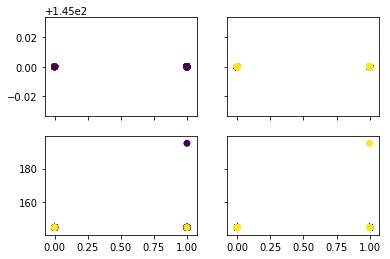

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[24:03:55<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3e195e47-f7e2-4578-9e6f-fab791c1b872


          
  0% |          |[24:03:56<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3e195e47-f7e2-4578-9e6f-fab791c1b872


          
  0% |          |[24:03:56<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  106.73% /s] 
  0% |          |[24:03:56<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.73% /s] 


CrowdAI.Event.Job.INFO : (3e195e47-f7e2-4578-9e6f-fab791c1b872) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -8.05469054583 ; MSE : 920.454409489
CrowdAI.Event.Job.COMPLETE : 3e195e47-f7e2-4578-9e6f-fab791c1b872	   🍺 


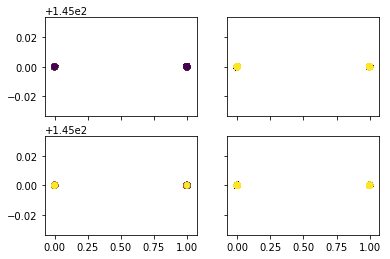

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[24:03:59<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 7c3684f6-ba3a-475d-afbf-d1b286156b47


          
  0% |          |[24:04:00<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 7c3684f6-ba3a-475d-afbf-d1b286156b47


          
  0% |          |[24:04:00<?]  ?% /s] 
  0% |          |[00:01<?]  ?% /s] 
          ██████|[00:01<00:00]  91.50% /s] 
  0% |          |[24:04:00<?]  ?% /s] 
100% |██████████|[00:01<00:00]  91.50% /s] 


CrowdAI.Event.Job.INFO : (7c3684f6-ba3a-475d-afbf-d1b286156b47) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -8.05469054583 ; MSE : 920.454409489
CrowdAI.Event.Job.COMPLETE : 7c3684f6-ba3a-475d-afbf-d1b286156b47	   🍺 


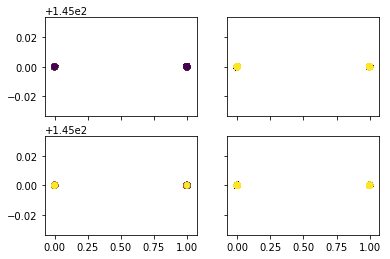

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[24:04:04<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d84ff48b-0ad7-44e7-a09c-2e97bd0a3c59


          
  0% |          |[24:04:04<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d84ff48b-0ad7-44e7-a09c-2e97bd0a3c59


          
  0% |          |[24:04:04<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  101.22% /s] 
  0% |          |[24:04:04<?]  ?% /s] 
100% |██████████|[00:00<00:00]  101.22% /s] 


CrowdAI.Event.Job.INFO : (d84ff48b-0ad7-44e7-a09c-2e97bd0a3c59) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -8.05469054583 ; MSE : 920.454409489
CrowdAI.Event.Job.COMPLETE : d84ff48b-0ad7-44e7-a09c-2e97bd0a3c59	   🍺 


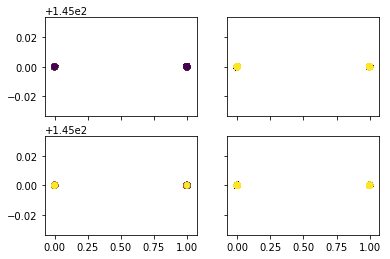

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[24:04:08<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 6d400d82-5a02-4e24-a067-3a86f072a3a9



          
  0% |          |[24:04:08<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 6d400d82-5a02-4e24-a067-3a86f072a3a9



          
  0% |          |[24:04:08<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.75% /s] 
          
  0% |          |[24:04:08<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (6d400d82-5a02-4e24-a067-3a86f072a3a9) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -8.05469054583 ; MSE : 920.454409489
CrowdAI.Event.Job.COMPLETE : 6d400d82-5a02-4e24-a067-3a86f072a3a9	   🍺 


In [311]:
lg_all = topsnp_model(m=linear_model.LinearRegression(),X=X,y=yb,df_test=df_test,val_idx=val_idx)

## 1.2 Residual Linear Model (remove gender and nationality)

### 1.2.a Linear model (gender and nationality) as a base model

In [332]:
#Load training data
x_train = X[['gender','nationality']]
y_train = y
x_test = df_test[['gender','nationality']]

# Instantiate a linear model
gender_nation_ml = linear_model.LinearRegression()
gender_nation_ml.fit(x_train, y_train)

# Predict the heights for the test set
heights = gender_nation_ml.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 97a31123-f47b-493d-9feb-515823ad3a0d


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 97a31123-f47b-493d-9feb-515823ad3a0d


100% |██████████|[00:00<00:00]  105.96% /s] 


CrowdAI.Event.Job.INFO : (97a31123-f47b-493d-9feb-515823ad3a0d) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.418981198924 ; MSE : 59.0634560883
CrowdAI.Event.Job.COMPLETE : 97a31123-f47b-493d-9feb-515823ad3a0d	   🍺 


(array([   8.,   28.,  137.,  511., 1051., 1053.,  574.,  147.,   19.,    2.]),
 array([-25.33765, -20.31765, -15.29765, -10.27765,  -5.25765,  -0.23765,   4.78235,   9.80235,  14.82235,
         19.84235,  24.86235]),
 <a list of 10 Patch objects>)

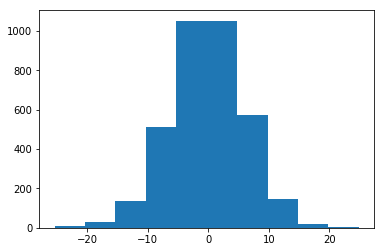

In [333]:
plt.hist(y_train-gender_nation_ml.predict(x_train))

In [334]:
base=gender_nation_ml.intercept_+np.dot(x_train,gender_nation_ml.coef_)

In [335]:
y_residual=y_train-gender_nation_ml.predict(x_train)

### 1.2.b1 linear regression for residual model

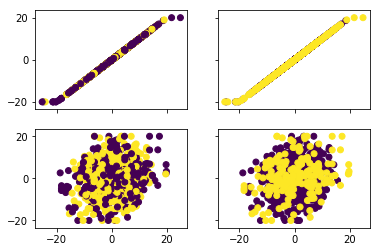

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : e3cda71a-a18c-4158-a205-bac69e8fc796


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : e3cda71a-a18c-4158-a205-bac69e8fc796


100% |██████████|[00:00<00:00]  110.59% /s] 


CrowdAI.Event.Job.INFO : (e3cda71a-a18c-4158-a205-bac69e8fc796) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.131924311751 ; MSE : 115.065746166
CrowdAI.Event.Job.COMPLETE : e3cda71a-a18c-4158-a205-bac69e8fc796	   🍺 


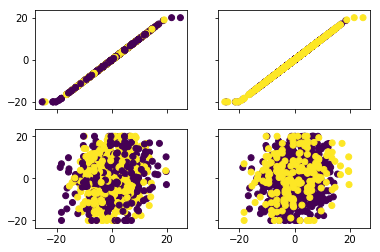

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : b20677b7-e7c5-4b06-85f4-5d33f4c86588


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : b20677b7-e7c5-4b06-85f4-5d33f4c86588


100% |██████████|[00:00<00:00]  107.54% /s] 


CrowdAI.Event.Job.INFO : (b20677b7-e7c5-4b06-85f4-5d33f4c86588) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.426169335076 ; MSE : 144.97721888
CrowdAI.Event.Job.COMPLETE : b20677b7-e7c5-4b06-85f4-5d33f4c86588	   🍺 


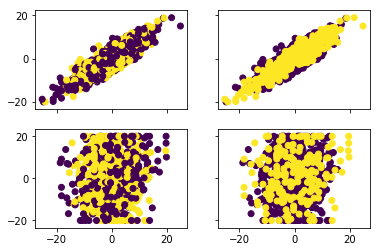

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 7125ac99-bd7c-4776-bc77-12871f392a41


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 7125ac99-bd7c-4776-bc77-12871f392a41


100% |██████████|[00:00<00:00]  100.99% /s] 


CrowdAI.Event.Job.INFO : (7125ac99-bd7c-4776-bc77-12871f392a41) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.622226962415 ; MSE : 164.907453567
CrowdAI.Event.Job.COMPLETE : 7125ac99-bd7c-4776-bc77-12871f392a41	   🍺 


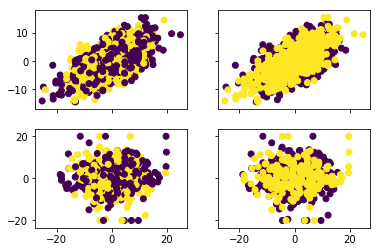

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d7bd5f97-6d96-472f-9294-b64afd6675c9


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d7bd5f97-6d96-472f-9294-b64afd6675c9


100% |██████████|[00:00<00:00]  104.43% /s] 


CrowdAI.Event.Job.INFO : (d7bd5f97-6d96-472f-9294-b64afd6675c9) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.0246202954194 ; MSE : 104.157758258
CrowdAI.Event.Job.COMPLETE : d7bd5f97-6d96-472f-9294-b64afd6675c9	   🍺 


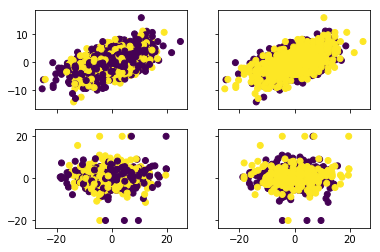

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : dd9cf132-c8a7-49ab-b8cc-ec31cc3f3a9a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : dd9cf132-c8a7-49ab-b8cc-ec31cc3f3a9a


100% |██████████|[00:00<00:00]  107.57% /s] 


CrowdAI.Event.Job.INFO : (dd9cf132-c8a7-49ab-b8cc-ec31cc3f3a9a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.153569878298 ; MSE : 86.0438392568
CrowdAI.Event.Job.COMPLETE : dd9cf132-c8a7-49ab-b8cc-ec31cc3f3a9a	   🍺 


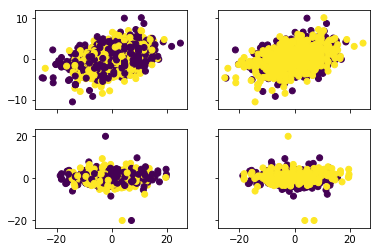

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : f2b9834e-187d-438c-bcdc-f5c8930be1d1


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : f2b9834e-187d-438c-bcdc-f5c8930be1d1


100% |██████████|[00:00<00:00]  108.90% /s] 


CrowdAI.Event.Job.INFO : (f2b9834e-187d-438c-bcdc-f5c8930be1d1) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.380314366494 ; MSE : 62.9941322645
CrowdAI.Event.Job.COMPLETE : f2b9834e-187d-438c-bcdc-f5c8930be1d1	   🍺 


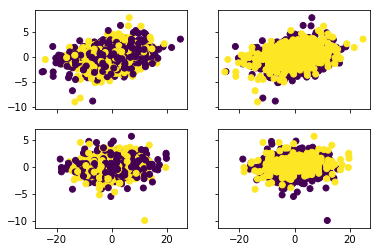

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d248431a-081a-4de0-b720-74cb44c86207


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d248431a-081a-4de0-b720-74cb44c86207


100% |██████████|[00:00<00:00]  107.10% /s] 


CrowdAI.Event.Job.INFO : (d248431a-081a-4de0-b720-74cb44c86207) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.410784229214 ; MSE : 59.8967189012
CrowdAI.Event.Job.COMPLETE : d248431a-081a-4de0-b720-74cb44c86207	   🍺 


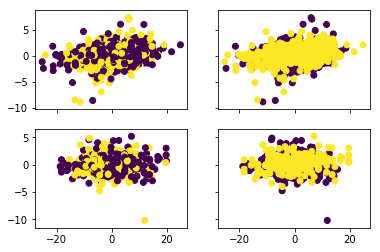

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d75b7695-7e67-4f6c-9e0a-e83af86b5058


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d75b7695-7e67-4f6c-9e0a-e83af86b5058


100% |██████████|[00:00<00:00]  107.68% /s] 


CrowdAI.Event.Job.INFO : (d75b7695-7e67-4f6c-9e0a-e83af86b5058) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.401921353822 ; MSE : 60.7976743446
CrowdAI.Event.Job.COMPLETE : d75b7695-7e67-4f6c-9e0a-e83af86b5058	   🍺 


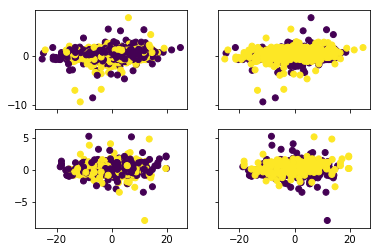

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 7be0d82b-5ac9-4f5c-8d69-85a837af6b15


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 7be0d82b-5ac9-4f5c-8d69-85a837af6b15


100% |██████████|[00:00<00:00]  102.82% /s] 


CrowdAI.Event.Job.INFO : (7be0d82b-5ac9-4f5c-8d69-85a837af6b15) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.404114611801 ; MSE : 60.5747187429
CrowdAI.Event.Job.COMPLETE : 7be0d82b-5ac9-4f5c-8d69-85a837af6b15	   🍺 


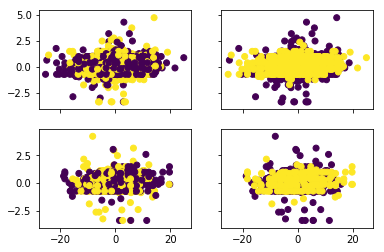

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 88e2fea5-2c4b-42ab-925c-9fc117e522e1


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 88e2fea5-2c4b-42ab-925c-9fc117e522e1


100% |██████████|[00:00<00:00]  110.92% /s] 


CrowdAI.Event.Job.INFO : (88e2fea5-2c4b-42ab-925c-9fc117e522e1) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.416292713188 ; MSE : 59.3367540589
CrowdAI.Event.Job.COMPLETE : 88e2fea5-2c4b-42ab-925c-9fc117e522e1	   🍺 


In [336]:
score_list={}
submit={}
for n in [7726, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10]:
    var_idx = list(range(n))
    gn_idx = list([7726,7727])
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.iloc[:,var_idx].values, np.array(y_residual))
    ((val_gn,trn_gn), (y_val_gn,y_trn_gn)) = split_by_idx(val_idx, X.iloc[:,gn_idx].values, np.array(y_residual))
    x_test = df_test.iloc[:,var_idx].values
    x_test_gn = df_test.iloc[:,gn_idx].values
    # Instantiate a linear model
    regr = linear_model.LinearRegression()
    regr.fit(trn, y_trn)
    

    preds = np.clip(regr.predict(trn),-20,20)
    preds1 = np.clip(regr.predict(val),-20,20)

    score_list[n]=(regr.score(trn, y_trn), regr.score(val, y_val))

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    ax1.scatter(y_trn,preds,c=trn_gn[:,-2], marker='o')
    ax2.scatter(y_trn,preds,c=trn_gn[:,-1], marker='o')
    ax3.scatter(y_val,preds1,c=val_gn[:,-2], marker='o')
    ax4.scatter(y_val,preds1,c=val_gn[:,-1], marker='o')
    plt.show()

    base=gender_nation_ml.intercept_+np.dot(x_test_gn,gender_nation_ml.coef_)
    heights = (base+np.clip(regr.predict(x_test),-20,20)).tolist()
    # Create the challenge object by authentication with crowdAI with your API_KEY
    challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
    submit[n]=challenge.submit(heights)
    challenge.disconnect()


In [337]:
score_list

{7726: (1.0, -1.088085859819723),
 5000: (1.0, -1.9969156360023603),
 2000: (0.7913509011988755, -4.3966044515733674e+20),
 1000: (0.391612671588738, -2.4296169613043773e+23),
 500: (0.24392631571634205, -4.598653589879166e+21),
 200: (0.11192478479730772, -4.936900294159033e+21),
 100: (0.0602821992740773, -0.029096329721072456),
 50: (0.03956723344705004, -0.015313614237283835),
 20: (0.019429847528654398, -0.004668040315134903),
 10: (0.011016016139863694, 0.0025403701385326993)}

### 1.2.b2 random forest for residual model

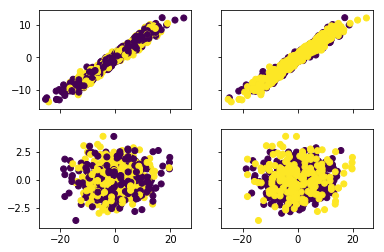

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : f5f9ce6a-9ef9-4535-ad98-3179375c0f7d


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : f5f9ce6a-9ef9-4535-ad98-3179375c0f7d


100% |██████████|[00:00<00:00]  107.59% /s] 


CrowdAI.Event.Job.INFO : (f5f9ce6a-9ef9-4535-ad98-3179375c0f7d) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.421207707618 ; MSE : 58.8371203858
CrowdAI.Event.Job.COMPLETE : f5f9ce6a-9ef9-4535-ad98-3179375c0f7d	   🍺 


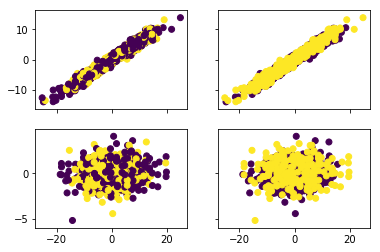

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 9936d767-4531-4487-af64-5ba82d3ac1eb


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 9936d767-4531-4487-af64-5ba82d3ac1eb


100% |██████████|[00:00<00:00]  106.73% /s] 


CrowdAI.Event.Job.INFO : (9936d767-4531-4487-af64-5ba82d3ac1eb) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.407882061856 ; MSE : 60.1917386733
CrowdAI.Event.Job.COMPLETE : 9936d767-4531-4487-af64-5ba82d3ac1eb	   🍺 


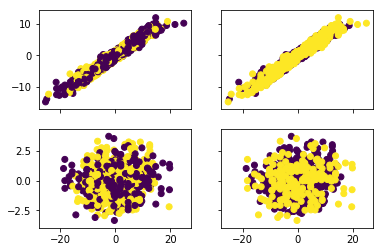

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bec7d289-b7b4-4bc9-af3c-f72ab9f3d711


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bec7d289-b7b4-4bc9-af3c-f72ab9f3d711


100% |██████████|[00:00<00:00]  106.68% /s] 


CrowdAI.Event.Job.INFO : (bec7d289-b7b4-4bc9-af3c-f72ab9f3d711) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.389119003449 ; MSE : 62.0990970484
CrowdAI.Event.Job.COMPLETE : bec7d289-b7b4-4bc9-af3c-f72ab9f3d711	   🍺 


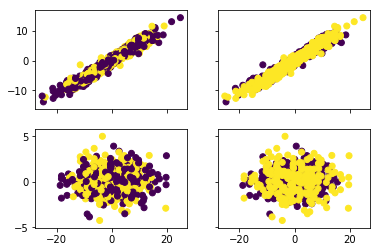

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 46717cdc-e24c-4eda-bbb1-611e0f4f5e81


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 46717cdc-e24c-4eda-bbb1-611e0f4f5e81


100% |██████████|[00:00<00:00]  103.70% /s] 


CrowdAI.Event.Job.INFO : (46717cdc-e24c-4eda-bbb1-611e0f4f5e81) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.431832589948 ; MSE : 57.7570481579
CrowdAI.Event.Job.COMPLETE : 46717cdc-e24c-4eda-bbb1-611e0f4f5e81	   🍺 


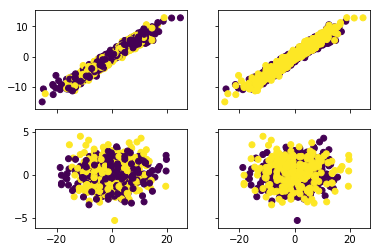

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : c3ae69be-6835-40f9-954d-2f7fd711d8b3


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : c3ae69be-6835-40f9-954d-2f7fd711d8b3


100% |██████████|[00:00<00:00]  109.38% /s] 


CrowdAI.Event.Job.INFO : (c3ae69be-6835-40f9-954d-2f7fd711d8b3) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.406098379895 ; MSE : 60.373058832
CrowdAI.Event.Job.COMPLETE : c3ae69be-6835-40f9-954d-2f7fd711d8b3	   🍺 


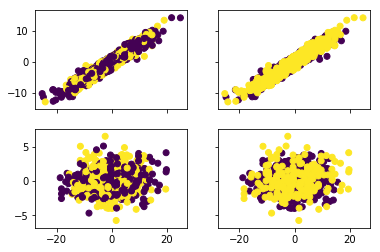

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : eddf91a6-38ab-4e67-afd7-000d8af83f5b


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : eddf91a6-38ab-4e67-afd7-000d8af83f5b


100% |██████████|[00:00<00:00]  110.11% /s] 


CrowdAI.Event.Job.INFO : (eddf91a6-38ab-4e67-afd7-000d8af83f5b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.385591412716 ; MSE : 62.4576942228
CrowdAI.Event.Job.COMPLETE : eddf91a6-38ab-4e67-afd7-000d8af83f5b	   🍺 


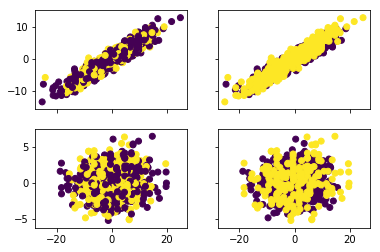

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : e6452fb3-6982-4d17-827e-c781f2711645


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : e6452fb3-6982-4d17-827e-c781f2711645


100% |██████████|[00:00<00:00]  106.10% /s] 


CrowdAI.Event.Job.INFO : (e6452fb3-6982-4d17-827e-c781f2711645) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.372027665373 ; MSE : 63.8365167224
CrowdAI.Event.Job.COMPLETE : e6452fb3-6982-4d17-827e-c781f2711645	   🍺 


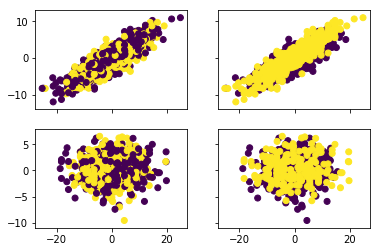

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 9dfe71e2-9e36-4076-b97d-4e9115eec1fd


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 9dfe71e2-9e36-4076-b97d-4e9115eec1fd


100% |██████████|[00:00<00:00]  105.95% /s] 


CrowdAI.Event.Job.INFO : (9dfe71e2-9e36-4076-b97d-4e9115eec1fd) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.358182389668 ; MSE : 65.2439579827
CrowdAI.Event.Job.COMPLETE : 9dfe71e2-9e36-4076-b97d-4e9115eec1fd	   🍺 


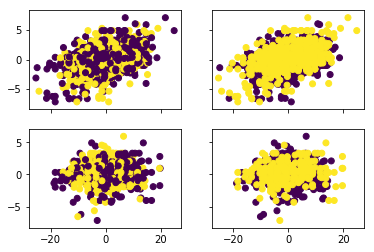

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 69d33ac7-046d-4cf0-ae78-ca97ebe8fa48


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 69d33ac7-046d-4cf0-ae78-ca97ebe8fa48


100% |██████████|[00:00<00:00]  105.62% /s] 


CrowdAI.Event.Job.INFO : (69d33ac7-046d-4cf0-ae78-ca97ebe8fa48) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.415453623337 ; MSE : 59.4220517231
CrowdAI.Event.Job.COMPLETE : 69d33ac7-046d-4cf0-ae78-ca97ebe8fa48	   🍺 


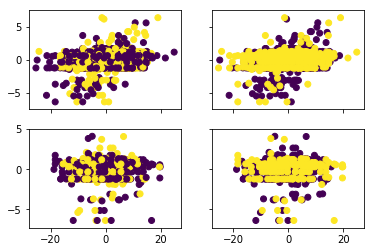

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 2a9b661e-fd3e-4f70-aac2-1a32194addab


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 2a9b661e-fd3e-4f70-aac2-1a32194addab


100% |██████████|[00:00<00:00]  107.10% /s] 


CrowdAI.Event.Job.INFO : (2a9b661e-fd3e-4f70-aac2-1a32194addab) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.421725488579 ; MSE : 58.7844853713
CrowdAI.Event.Job.COMPLETE : 2a9b661e-fd3e-4f70-aac2-1a32194addab	   🍺 


In [338]:
score_list_rrf={}
submit_rrf={}
for n in [7726, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10]:
    var_idx = list(range(n))
    gn_idx = list([7726,7727])
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.iloc[:,var_idx].values, np.array(y_residual))
    ((val_gn,trn_gn), (y_val_gn,y_trn_gn)) = split_by_idx(val_idx, X.iloc[:,gn_idx].values, np.array(y_residual))
    x_test = df_test.iloc[:,var_idx].values
    x_test_gn = df_test.iloc[:,gn_idx].values
    
    r_rf = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                                n_jobs=-1, oob_score=True)
    r_rf.fit(trn, y_trn)
    

    preds = np.clip(r_rf.predict(trn),-20,20)
    preds1 = np.clip(r_rf.predict(val),-20,20)

    score_list_rrf[n]=(r_rf.score(trn, y_trn), r_rf.score(val, y_val),r_rf.oob_score_)

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    ax1.scatter(y_trn,preds,c=trn_gn[:,-2], marker='o')
    ax2.scatter(y_trn,preds,c=trn_gn[:,-1], marker='o')
    ax3.scatter(y_val,preds1,c=val_gn[:,-2], marker='o')
    ax4.scatter(y_val,preds1,c=val_gn[:,-1], marker='o')
    plt.show()

    base=gender_nation_ml.intercept_+np.dot(x_test_gn,gender_nation_ml.coef_)
    heights = (base+np.clip(r_rf.predict(x_test),-20,20)).tolist()
    # Create the challenge object by authentication with crowdAI with your API_KEY
    challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
    submit_rrf[n]=challenge.submit(heights)
    challenge.disconnect()


In [339]:
score_list_rrf

{7726: (0.8335553236162933, -0.010198940132952306, -0.059180620254124294),
 5000: (0.836766090771654, 0.0011891800448405876, -0.045126388672741546),
 2000: (0.8332234211149894, -0.0002726024276382688, -0.043326041806910354),
 1000: (0.8289859994843152, -0.001822922884563205, -0.034313954346612),
 500: (0.8251159695656314, -0.00995477578827031, -0.02133823949342295),
 200: (0.8065929270251828, -0.01424438946751927, -0.04618796972256067),
 100: (0.7675238772476022, -0.037528937118384675, -0.08294553678859273),
 50: (0.6430595122593328, -0.08810539020948327, -0.1104591015215306),
 20: (0.10931998477984374, -0.022910334485140238, -0.037324508705530945),
 10: (0.04043294349344928, -0.023181706609162633, -0.013282116317610893)}

# 2. OS DATA

In [309]:
def topsnp_model(m,X,y,df_test,val_idx,residual=False,topn=[7726, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10]):
    score_list={}
    submit={}
    for n in topn:
        if residual:
            var_idx = list(range(n))
            ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.iloc[:,var_idx].values, np.array(y))
            x_test = df_test.iloc[:,var_idx].values
            gn_idx = list([7726,7727])
            ((val_gn,trn_gn), (y_val_gn,y_trn_gn)) = split_by_idx(val_idx, X.iloc[:,gn_idx].values, np.array(y))
            x_test_gn = df_test.iloc[:,gn_idx].values
        else:
            var_idx = list(range(n))+list([7726,7727])
            ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.iloc[:,var_idx].values, np.array(y))
            x_test = df_test.iloc[:,var_idx].values

        ml = m
        ml.fit(trn, y_trn)
        
        if residual:
            preds = np.clip(ml.predict(trn),-20,20)
            preds1 = np.clip(ml.predict(val),-20,20)
            f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
            ax1.scatter(y_trn,preds,c=trn_gn[:,-2], marker='o')
            ax2.scatter(y_trn,preds,c=trn_gn[:,-1], marker='o')
            ax3.scatter(y_val,preds1,c=val_gn[:,-2], marker='o')
            ax4.scatter(y_val,preds1,c=val_gn[:,-1], marker='o')
            plt.show()
            base=gender_nation_ml.intercept_+np.dot(x_test_gn,gender_nation_ml.coef_)
            heights = (base+np.clip(ml.predict(x_test),-20,20)).tolist()
        else:
            preds = np.clip(ml.predict(trn),145,195)
            preds1 = np.clip(ml.predict(val),145,195)
            f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
            ax1.scatter(y_trn,preds,c=trn[:,-2], marker='o')
            ax2.scatter(y_trn,preds,c=trn[:,-1], marker='o')
            ax3.scatter(y_val,preds1,c=val[:,-2], marker='o')
            ax4.scatter(y_val,preds1,c=val[:,-1], marker='o')
            plt.show()
            heights = np.clip(ml.predict(x_test),145,195).tolist()
        
        score_list[n]=(ml.score(trn, y_trn), ml.score(val, y_val))
        # Create the challenge object by authentication with crowdAI with your API_KEY
        challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
        submit[n]=challenge.submit(heights)
        challenge.disconnect()
    return (score_list,submit)

## 2.1 Linear model with os data

### Sample seperation of os data

783 626


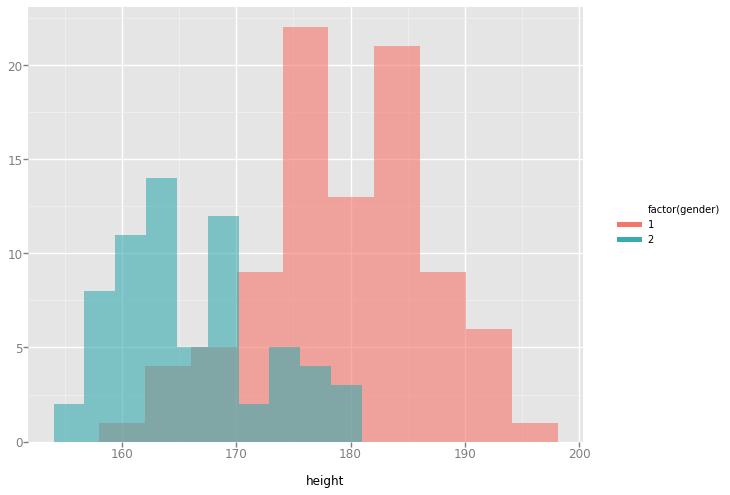

<ggplot: (-9223363276567660200)>

In [167]:
os_meta = all_meta.iloc[2747:3530,]
samp_size=len(os_meta)
train_ratio = 0.8
train_size = int(samp_size * train_ratio)

import random
os_val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
ggplot( aes(x='height',fill='factor(gender)'),data=os_meta.iloc[os_val_idx,]) +\
    geom_histogram(alpha=0.6)

### 2.1.1 Linear Model with os data by top 10000, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10 snps

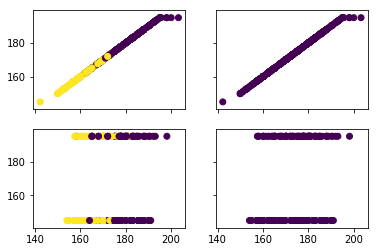

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:10:34<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 63666d28-522f-4c1b-9840-480cc0dda7c8



          
  0% |          |[18:10:34<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 63666d28-522f-4c1b-9840-480cc0dda7c8



          
  0% |          |[18:10:35<?]  ?% /s] 
100% |██████████|[00:00<00:00]  107.60% /s] 
          
  0% |          |[18:10:35<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (63666d28-522f-4c1b-9840-480cc0dda7c8) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -6.73966565718 ; MSE : 786.775577372
CrowdAI.Event.Job.COMPLETE : 63666d28-522f-4c1b-9840-480cc0dda7c8	   🍺 


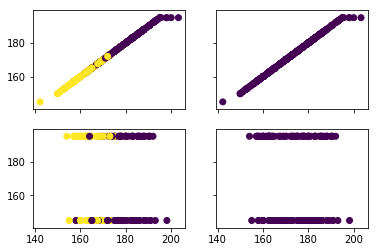

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:10:38<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : e7422756-ccc2-4d87-a4ce-6cc33073cb8b



          
  0% |          |[18:10:38<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : e7422756-ccc2-4d87-a4ce-6cc33073cb8b



          
  0% |          |[18:10:39<?]  ?% /s] 
100% |██████████|[00:01<00:00]  97.90% /s] 
          
  0% |          |[18:10:39<?]  ?% /s]  /s] 


CrowdAI.Event.Job.INFO : (e7422756-ccc2-4d87-a4ce-6cc33073cb8b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -5.40934644171 ; MSE : 651.54200073
CrowdAI.Event.Job.COMPLETE : e7422756-ccc2-4d87-a4ce-6cc33073cb8b	   🍺 


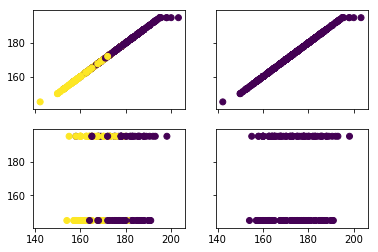

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:10:42<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 5125dcbc-66f8-438c-b22c-68dcec4e90a5



          
  0% |          |[18:10:42<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 5125dcbc-66f8-438c-b22c-68dcec4e90a5



          
  0% |          |[18:10:42<?]  ?% /s] 
100% |██████████|[00:00<00:00]  101.10% /s] 
          
  0% |          |[18:10:42<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (5125dcbc-66f8-438c-b22c-68dcec4e90a5) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -6.17636052168 ; MSE : 729.51280365
CrowdAI.Event.Job.COMPLETE : 5125dcbc-66f8-438c-b22c-68dcec4e90a5	   🍺 


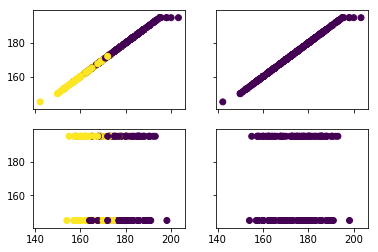

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:10:46<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : b3f8eb39-9ba4-443a-aad2-87646ea3b50b



          
  0% |          |[18:10:46<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : b3f8eb39-9ba4-443a-aad2-87646ea3b50b



          
  0% |          |[18:10:46<?]  ?% /s] 
100% |██████████|[00:00<00:00]  108.44% /s] 
          
  0% |          |[18:10:46<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (b3f8eb39-9ba4-443a-aad2-87646ea3b50b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -5.90091903032 ; MSE : 701.51280365
CrowdAI.Event.Job.COMPLETE : b3f8eb39-9ba4-443a-aad2-87646ea3b50b	   🍺 


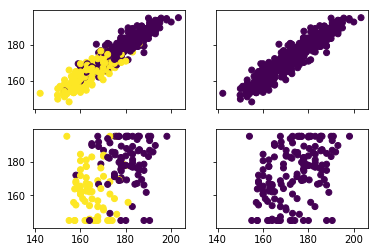

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:10:49<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d3826e94-4e69-4461-9ae0-d072afa18cfe



          
  0% |          |[18:10:50<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d3826e94-4e69-4461-9ae0-d072afa18cfe



          
  0% |          |[18:10:50<?]  ?% /s] 
100% |██████████|[00:00<00:00]  105.36% /s] 
          
  0% |          |[18:10:50<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (d3826e94-4e69-4461-9ae0-d072afa18cfe) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -1.13575906178 ; MSE : 217.11055017
CrowdAI.Event.Job.COMPLETE : d3826e94-4e69-4461-9ae0-d072afa18cfe	   🍺 


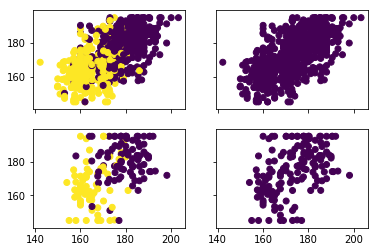

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:10:53<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 24da3bcd-d491-4875-a2e2-c497e96e257f



          
  0% |          |[18:10:53<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 24da3bcd-d491-4875-a2e2-c497e96e257f



          
  0% |          |[18:10:54<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.54% /s] 
          
  0% |          |[18:10:54<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (24da3bcd-d491-4875-a2e2-c497e96e257f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -1.00868740152 ; MSE : 204.193082763
CrowdAI.Event.Job.COMPLETE : 24da3bcd-d491-4875-a2e2-c497e96e257f	   🍺 


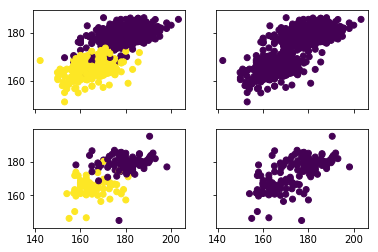

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:10:57<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 00ba4e21-38e2-4aa8-a1fe-b42c8ea6c251



          
  0% |          |[18:10:57<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 00ba4e21-38e2-4aa8-a1fe-b42c8ea6c251



          
  0% |          |[18:10:57<?]  ?% /s] 
100% |██████████|[00:00<00:00]  105.78% /s] 
          
  0% |          |[18:10:57<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (00ba4e21-38e2-4aa8-a1fe-b42c8ea6c251) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.362962034561 ; MSE : 64.7580832645
CrowdAI.Event.Job.COMPLETE : 00ba4e21-38e2-4aa8-a1fe-b42c8ea6c251	   🍺 


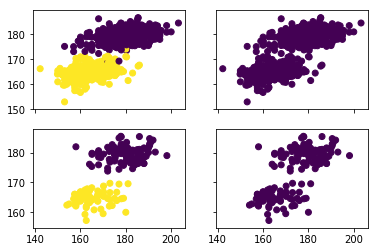

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:11:01<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 268c8880-a0a0-43d3-8fc1-eb7d984e2c49



          
  0% |          |[18:11:01<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 268c8880-a0a0-43d3-8fc1-eb7d984e2c49



          
  0% |          |[18:11:01<?]  ?% /s] 
100% |██████████|[00:00<00:00]  108.29% /s] 
          
  0% |          |[18:11:01<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (268c8880-a0a0-43d3-8fc1-eb7d984e2c49) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.398704599367 ; MSE : 61.1246734626
CrowdAI.Event.Job.COMPLETE : 268c8880-a0a0-43d3-8fc1-eb7d984e2c49	   🍺 


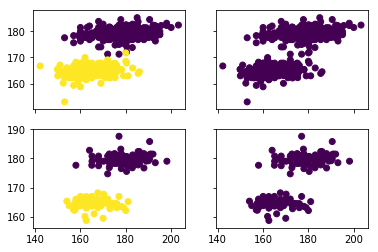

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:11:04<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 96a1cc3c-ab9c-4c61-84ed-15c2382f8346



          
  0% |          |[18:11:05<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 96a1cc3c-ab9c-4c61-84ed-15c2382f8346



          
  0% |          |[18:11:05<?]  ?% /s] 
100% |██████████|[00:00<00:00]  107.51% /s] 
          
  0% |          |[18:11:05<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (96a1cc3c-ab9c-4c61-84ed-15c2382f8346) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.401380619812 ; MSE : 60.8526426509
CrowdAI.Event.Job.COMPLETE : 96a1cc3c-ab9c-4c61-84ed-15c2382f8346	   🍺 


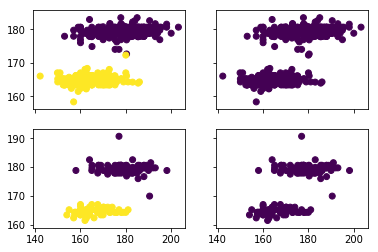

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:11:08<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ef348ff4-bcba-4dcb-91d9-f766b70e1e14



          
  0% |          |[18:11:08<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ef348ff4-bcba-4dcb-91d9-f766b70e1e14



          
  0% |          |[18:11:09<?]  ?% /s] 
100% |██████████|[00:00<00:00]  107.56% /s] 
          
  0% |          |[18:11:09<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (ef348ff4-bcba-4dcb-91d9-f766b70e1e14) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.419339952596 ; MSE : 59.02698699
CrowdAI.Event.Job.COMPLETE : ef348ff4-bcba-4dcb-91d9-f766b70e1e14	   🍺 


In [171]:
lm_os = topsnp_model(m=linear_model.LinearRegression(),X=X.iloc[2747:3530,],y=y.iloc[2747:3530,],df_test=df_test,val_idx=os_val_idx)

### 2.1.2 Residual Model with os data by top 10000, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10 snps

In [173]:
#Load training data
x_train = X.iloc[2747:3530,]
x_train = x_train[['gender','nationality']]
y_train = y.iloc[2747:3530,]
x_test = df_test[['gender','nationality']]

# Instantiate a linear model
os_gender_nation_ml = linear_model.LinearRegression()
os_gender_nation_ml.fit(x_train, y_train)

# Predict the heights for the test set
heights = os_gender_nation_ml.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:20:38<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 1ec85f5d-c8c3-4a95-8a33-f02570fe6bdc


          
  0% |          |[18:20:38<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 1ec85f5d-c8c3-4a95-8a33-f02570fe6bdc


          
  0% |          |[18:20:38<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  106.31% /s] 
  0% |          |[18:20:38<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.31% /s] 


CrowdAI.Event.Job.INFO : (1ec85f5d-c8c3-4a95-8a33-f02570fe6bdc) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.420750671304 ; MSE : 58.8835804044
CrowdAI.Event.Job.COMPLETE : 1ec85f5d-c8c3-4a95-8a33-f02570fe6bdc	   🍺 


(array([  5.,  12.,  42., 111., 192., 169., 169.,  61.,  18.,   4.]),
 array([-26.41888, -21.39888, -16.37888, -11.35888,  -6.33888,  -1.31888,   3.70112,   8.72112,  13.74112,
         18.76112,  23.78112]),
 <a list of 10 Patch objects>)

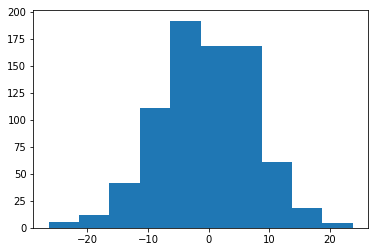

In [174]:
plt.hist(y_train-os_gender_nation_ml.predict(x_train))

In [175]:
y_residual=y_train-os_gender_nation_ml.predict(x_train)

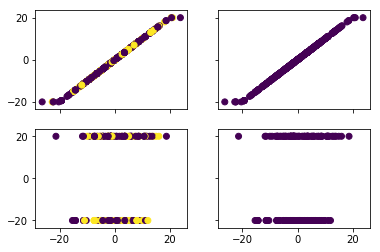

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:25:24<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : a0d6c9bc-9c93-469f-92cd-68b9b76ee56c



          
  0% |          |[18:25:24<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : a0d6c9bc-9c93-469f-92cd-68b9b76ee56c



          
  0% |          |[18:25:24<?]  ?% /s] 
100% |██████████|[00:01<00:00]  94.23% /s] 
          
  0% |          |[18:25:24<?]  ?% /s]  /s] 


CrowdAI.Event.Job.INFO : (a0d6c9bc-9c93-469f-92cd-68b9b76ee56c) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -3.6673113693 ; MSE : 474.455455831
CrowdAI.Event.Job.COMPLETE : a0d6c9bc-9c93-469f-92cd-68b9b76ee56c	   🍺 


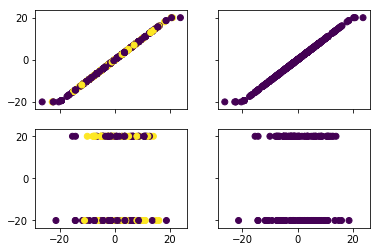

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:25:28<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 9837c8bc-6981-47da-bcf2-39f7d511514c



          
  0% |          |[18:25:28<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 9837c8bc-6981-47da-bcf2-39f7d511514c



          
  0% |          |[18:25:28<?]  ?% /s] 
100% |██████████|[00:00<00:00]  102.65% /s] 
          
  0% |          |[18:25:28<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (9837c8bc-6981-47da-bcf2-39f7d511514c) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -3.11969286575 ; MSE : 418.787306405
CrowdAI.Event.Job.COMPLETE : 9837c8bc-6981-47da-bcf2-39f7d511514c	   🍺 


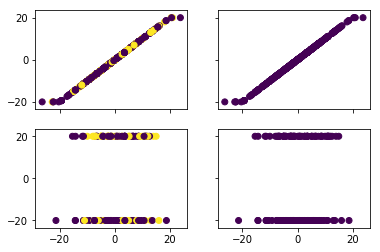

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:25:31<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 85e3fadb-c307-4811-af5a-c6026ea62327



          
  0% |          |[18:25:32<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 85e3fadb-c307-4811-af5a-c6026ea62327



          
  0% |          |[18:25:32<?]  ?% /s] 
100% |██████████|[00:00<00:00]  107.85% /s] 
          
  0% |          |[18:25:32<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (85e3fadb-c307-4811-af5a-c6026ea62327) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -3.45853385228 ; MSE : 453.232180981
CrowdAI.Event.Job.COMPLETE : 85e3fadb-c307-4811-af5a-c6026ea62327	   🍺 


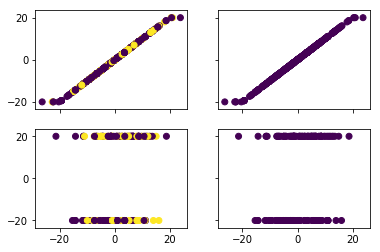

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:25:35<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : b310b7b1-1e2b-44b7-bf42-2e76deb936fb



          
  0% |          |[18:25:36<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : b310b7b1-1e2b-44b7-bf42-2e76deb936fb



          
  0% |          |[18:25:36<?]  ?% /s] 
100% |██████████|[00:00<00:00]  108.52% /s] 
          
  0% |          |[18:25:36<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (b310b7b1-1e2b-44b7-bf42-2e76deb936fb) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -3.52848516291 ; MSE : 460.343080243
CrowdAI.Event.Job.COMPLETE : b310b7b1-1e2b-44b7-bf42-2e76deb936fb	   🍺 


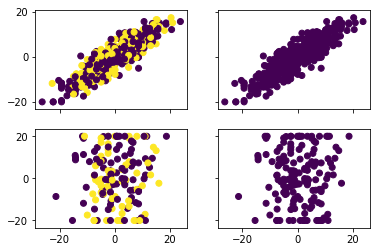

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:25:39<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : fcac5031-2d6a-4d07-807f-91a93817a426


          
  0% |          |[18:25:39<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : fcac5031-2d6a-4d07-807f-91a93817a426


          
  0% |          |[18:25:40<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  105.74% /s] 
  0% |          |[18:25:40<?]  ?% /s] 
100% |██████████|[00:00<00:00]  105.74% /s] 


CrowdAI.Event.Job.INFO : (fcac5031-2d6a-4d07-807f-91a93817a426) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.999833393577 ; MSE : 203.29302874
CrowdAI.Event.Job.COMPLETE : fcac5031-2d6a-4d07-807f-91a93817a426	   🍺 


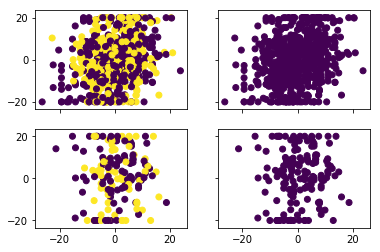

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:25:43<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 94f46e96-a9cb-4a9b-b5d0-2967091bbb68


          
  0% |          |[18:25:43<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 94f46e96-a9cb-4a9b-b5d0-2967091bbb68


          
  0% |          |[18:25:44<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  108.46% /s] 
  0% |          |[18:25:44<?]  ?% /s] 
100% |██████████|[00:00<00:00]  108.46% /s] 


CrowdAI.Event.Job.INFO : (94f46e96-a9cb-4a9b-b5d0-2967091bbb68) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.888107011859 ; MSE : 191.935485355
CrowdAI.Event.Job.COMPLETE : 94f46e96-a9cb-4a9b-b5d0-2967091bbb68	   🍺 


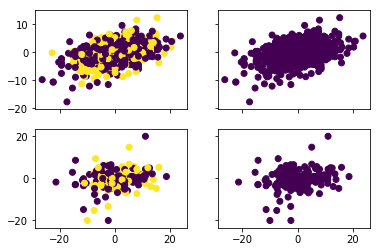

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:25:47<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ec12c2ff-195b-43fa-a175-45aac0414379



          
  0% |          |[18:25:47<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ec12c2ff-195b-43fa-a175-45aac0414379



          
  0% |          |[18:25:47<?]  ?% /s] 
100% |██████████|[00:00<00:00]  107.11% /s] 
          
  0% |          |[18:25:47<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (ec12c2ff-195b-43fa-a175-45aac0414379) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.377612430171 ; MSE : 63.2687975543
CrowdAI.Event.Job.COMPLETE : ec12c2ff-195b-43fa-a175-45aac0414379	   🍺 


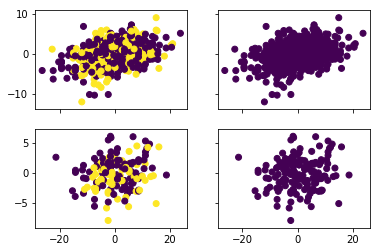

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:25:50<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : f0b42b13-8fba-4379-9ebe-9be0cd379738



          
  0% |          |[18:25:50<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : f0b42b13-8fba-4379-9ebe-9be0cd379738



          
  0% |          |[18:25:51<?]  ?% /s] 
100% |██████████|[00:00<00:00]  102.71% /s] 
          
  0% |          |[18:25:51<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (f0b42b13-8fba-4379-9ebe-9be0cd379738) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.398935675407 ; MSE : 61.1011834318
CrowdAI.Event.Job.COMPLETE : f0b42b13-8fba-4379-9ebe-9be0cd379738	   🍺 


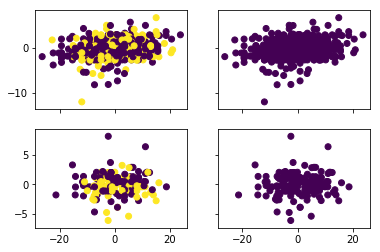

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:25:54<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 859f4307-4f9d-4f98-920c-fb8c79a77973



          
  0% |          |[18:25:54<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 859f4307-4f9d-4f98-920c-fb8c79a77973



          
  0% |          |[18:25:55<?]  ?% /s] 
100% |██████████|[00:00<00:00]  109.18% /s] 
          
  0% |          |[18:25:55<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (859f4307-4f9d-4f98-920c-fb8c79a77973) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.39944758642 ; MSE : 61.0491451266
CrowdAI.Event.Job.COMPLETE : 859f4307-4f9d-4f98-920c-fb8c79a77973	   🍺 


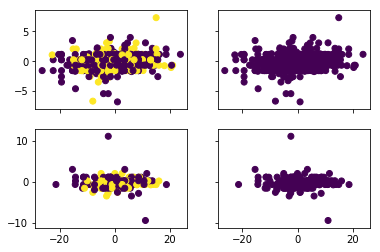

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:25:57<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 18029e48-1a1a-4231-9e2a-65ab287376e7


          
  0% |          |[18:25:58<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 18029e48-1a1a-4231-9e2a-65ab287376e7


          
  0% |          |[18:25:58<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  106.56% /s] 
  0% |          |[18:25:58<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.56% /s] 


CrowdAI.Event.Job.INFO : (18029e48-1a1a-4231-9e2a-65ab287376e7) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.417285669872 ; MSE : 59.2358150645
CrowdAI.Event.Job.COMPLETE : 18029e48-1a1a-4231-9e2a-65ab287376e7	   🍺 


In [179]:
lm_os_res = topsnp_model(m=linear_model.LinearRegression(),X=X.iloc[2747:3530,],y=y_residual,df_test=df_test,val_idx=os_val_idx,residual=True)

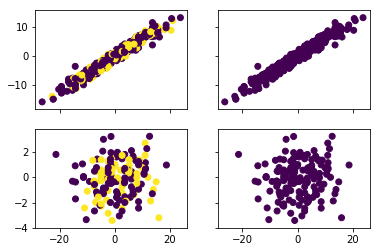

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:29:50<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : cc1af642-f44e-416d-b2ad-15815b3129f3



          
  0% |          |[18:29:50<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : cc1af642-f44e-416d-b2ad-15815b3129f3



          
  0% |          |[18:29:50<?]  ?% /s] 
100% |██████████|[00:00<00:00]  105.36% /s] 
          
  0% |          |[18:29:50<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (cc1af642-f44e-416d-b2ad-15815b3129f3) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.413829944166 ; MSE : 59.5871068009
CrowdAI.Event.Job.COMPLETE : cc1af642-f44e-416d-b2ad-15815b3129f3	   🍺 


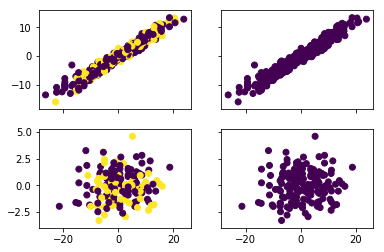

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:29:55<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 6c191bfb-df8b-4a40-b1a2-0f7b81f72a15



          
  0% |          |[18:29:55<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 6c191bfb-df8b-4a40-b1a2-0f7b81f72a15



          
  0% |          |[18:29:56<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.50% /s] 
          
  0% |          |[18:29:56<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (6c191bfb-df8b-4a40-b1a2-0f7b81f72a15) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.414466980095 ; MSE : 59.5223489246
CrowdAI.Event.Job.COMPLETE : 6c191bfb-df8b-4a40-b1a2-0f7b81f72a15	   🍺 


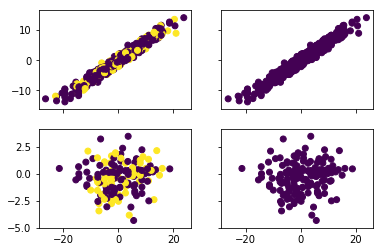

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:30:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : eedc8434-5eeb-42e1-b7c0-d16e6b44f161



          
  0% |          |[18:30:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : eedc8434-5eeb-42e1-b7c0-d16e6b44f161



          
  0% |          |[18:30:01<?]  ?% /s] 
100% |██████████|[00:01<00:00]  90.21% /s] 
          
  0% |          |[18:30:01<?]  ?% /s]  /s] 


CrowdAI.Event.Job.INFO : (eedc8434-5eeb-42e1-b7c0-d16e6b44f161) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.416618159236 ; MSE : 59.3036708465
CrowdAI.Event.Job.COMPLETE : eedc8434-5eeb-42e1-b7c0-d16e6b44f161	   🍺 


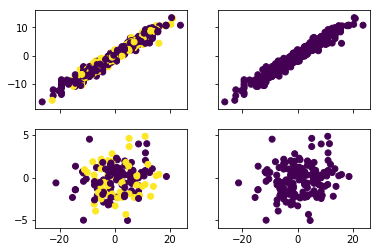

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:30:05<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 4ae230c6-e47d-47dd-a98b-d05798e8cfc2



          
  0% |          |[18:30:05<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 4ae230c6-e47d-47dd-a98b-d05798e8cfc2



          
  0% |          |[18:30:05<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.29% /s] 
          
  0% |          |[18:30:05<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (4ae230c6-e47d-47dd-a98b-d05798e8cfc2) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.418212690672 ; MSE : 59.1415787813
CrowdAI.Event.Job.COMPLETE : 4ae230c6-e47d-47dd-a98b-d05798e8cfc2	   🍺 


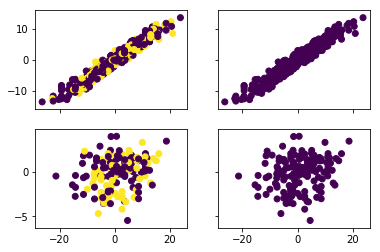

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:30:09<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 530b09e6-bb52-4b66-afab-d35b01bdc516



          
  0% |          |[18:30:09<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 530b09e6-bb52-4b66-afab-d35b01bdc516



          
  0% |          |[18:30:10<?]  ?% /s] 
100% |██████████|[00:00<00:00]  109.00% /s] 
          
  0% |          |[18:30:10<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (530b09e6-bb52-4b66-afab-d35b01bdc516) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.398994090279 ; MSE : 61.095245269
CrowdAI.Event.Job.COMPLETE : 530b09e6-bb52-4b66-afab-d35b01bdc516	   🍺 


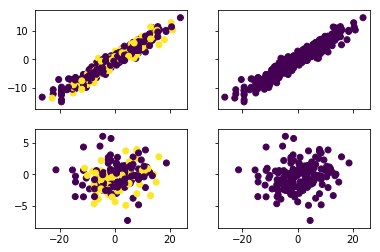

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:30:14<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 1125db28-d2b6-4445-80c8-99431af05127



          
  0% |          |[18:30:14<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 1125db28-d2b6-4445-80c8-99431af05127



          
  0% |          |[18:30:14<?]  ?% /s] 
100% |██████████|[00:00<00:00]  107.41% /s] 
          
  0% |          |[18:30:14<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (1125db28-d2b6-4445-80c8-99431af05127) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.371199011809 ; MSE : 63.920753486
CrowdAI.Event.Job.COMPLETE : 1125db28-d2b6-4445-80c8-99431af05127	   🍺 


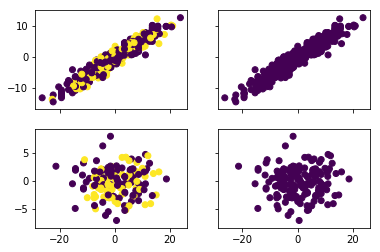

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:30:18<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 16d4efd7-d38d-4a72-b658-745992957407



          
  0% |          |[18:30:18<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 16d4efd7-d38d-4a72-b658-745992957407



          
  0% |          |[18:30:19<?]  ?% /s] 
100% |██████████|[00:00<00:00]  103.86% /s] 
          
  0% |          |[18:30:19<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (16d4efd7-d38d-4a72-b658-745992957407) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.390716107728 ; MSE : 61.9367434407
CrowdAI.Event.Job.COMPLETE : 16d4efd7-d38d-4a72-b658-745992957407	   🍺 


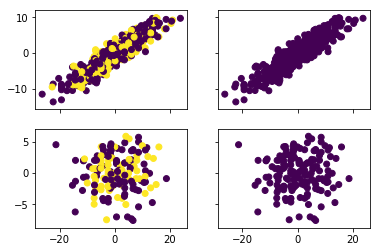

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:30:22<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 33fae0f7-20f1-4a31-a838-943476b0143b



          
  0% |          |[18:30:23<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 33fae0f7-20f1-4a31-a838-943476b0143b



          
  0% |          |[18:30:23<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.44% /s] 
          
  0% |          |[18:30:23<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (33fae0f7-20f1-4a31-a838-943476b0143b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.388943547186 ; MSE : 62.1169330517
CrowdAI.Event.Job.COMPLETE : 33fae0f7-20f1-4a31-a838-943476b0143b	   🍺 


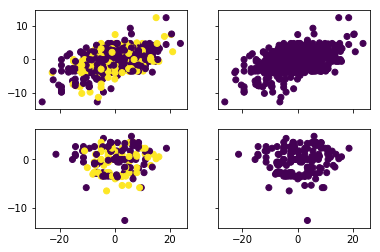

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:30:27<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 6ac2c5d0-7e9e-4e8c-b4b9-51834639e8c1


          
  0% |          |[18:30:27<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 6ac2c5d0-7e9e-4e8c-b4b9-51834639e8c1


          
  0% |          |[18:30:28<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  106.57% /s] 
  0% |          |[18:30:28<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.57% /s] 


CrowdAI.Event.Job.INFO : (6ac2c5d0-7e9e-4e8c-b4b9-51834639e8c1) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.327395795869 ; MSE : 68.3735686383
CrowdAI.Event.Job.COMPLETE : 6ac2c5d0-7e9e-4e8c-b4b9-51834639e8c1	   🍺 


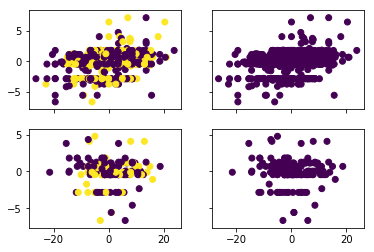

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:30:31<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 4249a476-a498-48d3-ab59-87a13ec8c76b


          
  0% |          |[18:30:32<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 4249a476-a498-48d3-ab59-87a13ec8c76b


          
  0% |          |[18:30:32<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  108.59% /s] 
  0% |          |[18:30:32<?]  ?% /s] 
100% |██████████|[00:00<00:00]  108.59% /s] 


CrowdAI.Event.Job.INFO : (4249a476-a498-48d3-ab59-87a13ec8c76b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.396440227609 ; MSE : 61.3548581342
CrowdAI.Event.Job.COMPLETE : 4249a476-a498-48d3-ab59-87a13ec8c76b	   🍺 


In [181]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
rf_os_res = topsnp_model(m=m,X=X.iloc[2747:3530,],y=y_residual,df_test=df_test,val_idx=os_val_idx,residual=True)

## 2.2 Random Forest with os data

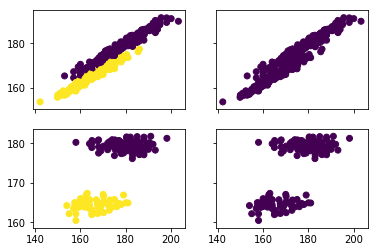

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:36:58<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : a8861aef-6c84-4f56-88d7-a8fea23cd3e5



          
  0% |          |[18:36:59<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : a8861aef-6c84-4f56-88d7-a8fea23cd3e5



          
  0% |          |[18:36:59<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.20% /s] 
          
  0% |          |[18:36:59<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (a8861aef-6c84-4f56-88d7-a8fea23cd3e5) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.423053785761 ; MSE : 58.6494573444
CrowdAI.Event.Job.COMPLETE : a8861aef-6c84-4f56-88d7-a8fea23cd3e5	   🍺 


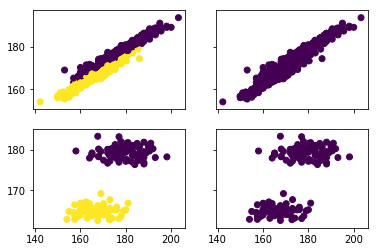

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:37:03<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3383f4ff-b7e2-4b71-a00d-177bdf84a0f1



          
  0% |          |[18:37:04<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3383f4ff-b7e2-4b71-a00d-177bdf84a0f1



          
  0% |          |[18:37:05<?]  ?% /s] 
100% |██████████|[00:01<00:00]  59.49% /s] 
          
  0% |          |[18:37:05<?]  ?% /s]  /s] 


CrowdAI.Event.Job.INFO : (3383f4ff-b7e2-4b71-a00d-177bdf84a0f1) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.428821862051 ; MSE : 58.0631036498
CrowdAI.Event.Job.COMPLETE : 3383f4ff-b7e2-4b71-a00d-177bdf84a0f1	   🍺 


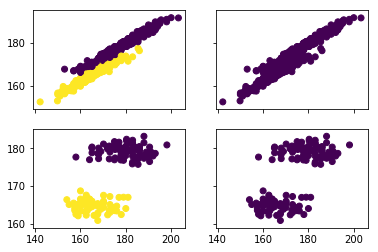

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:37:09<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 97859481-5e5d-4527-8bd8-d27886a2f78e



          
  0% |          |[18:37:09<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 97859481-5e5d-4527-8bd8-d27886a2f78e



          
  0% |          |[18:37:10<?]  ?% /s] 
100% |██████████|[00:01<00:00]  91.52% /s] 
          
  0% |          |[18:37:10<?]  ?% /s]  /s] 


CrowdAI.Event.Job.INFO : (97859481-5e5d-4527-8bd8-d27886a2f78e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.409538720187 ; MSE : 60.0233310996
CrowdAI.Event.Job.COMPLETE : 97859481-5e5d-4527-8bd8-d27886a2f78e	   🍺 


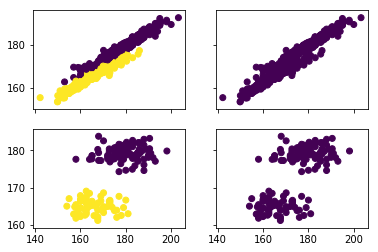

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:37:14<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : cfe91313-3aa7-4c30-84d0-355d3e877eee



          
  0% |          |[18:37:14<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : cfe91313-3aa7-4c30-84d0-355d3e877eee



          
  0% |          |[18:37:14<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.83% /s] 
          
  0% |          |[18:37:14<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (cfe91313-3aa7-4c30-84d0-355d3e877eee) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.404360333245 ; MSE : 60.5497399338
CrowdAI.Event.Job.COMPLETE : cfe91313-3aa7-4c30-84d0-355d3e877eee	   🍺 


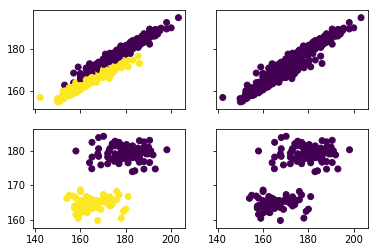

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[18:37:18<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 086c4a22-06b2-4f0a-adf9-aac32313305e



          
  0% |          |[18:37:19<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 086c4a22-06b2-4f0a-adf9-aac32313305e



          
  0% |          |[18:37:19<?]  ?% /s] 
100% |██████████|[00:00<00:00]  104.08% /s] 
          
  0% |          |[18:37:19<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (086c4a22-06b2-4f0a-adf9-aac32313305e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.390193975799 ; MSE : 61.9898207529
CrowdAI.Event.Job.COMPLETE : 086c4a22-06b2-4f0a-adf9-aac32313305e	   🍺 


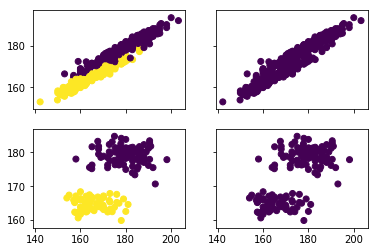

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:37:23<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 757a1092-4cfa-4905-95a5-e452043d909e


          
  0% |          |[18:37:23<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 757a1092-4cfa-4905-95a5-e452043d909e


          
  0% |          |[18:37:24<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  104.91% /s] 
  0% |          |[18:37:24<?]  ?% /s] 
100% |██████████|[00:00<00:00]  104.91% /s] 


CrowdAI.Event.Job.INFO : (757a1092-4cfa-4905-95a5-e452043d909e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.366697104142 ; MSE : 64.3783948313
CrowdAI.Event.Job.COMPLETE : 757a1092-4cfa-4905-95a5-e452043d909e	   🍺 


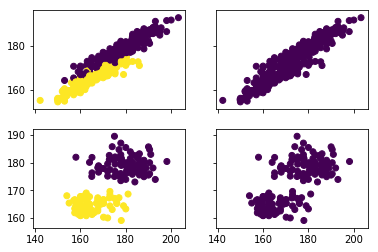

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:37:27<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 214beb17-911f-470f-959f-8d8200614afb


          
  0% |          |[18:37:28<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 214beb17-911f-470f-959f-8d8200614afb


          
  0% |          |[18:37:28<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  106.18% /s] 
  0% |          |[18:37:28<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.18% /s] 


CrowdAI.Event.Job.INFO : (214beb17-911f-470f-959f-8d8200614afb) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.360462556663 ; MSE : 65.0121676465
CrowdAI.Event.Job.COMPLETE : 214beb17-911f-470f-959f-8d8200614afb	   🍺 


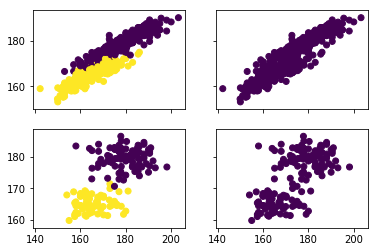

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:37:32<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : dc3de864-ea5d-4df6-a0b8-8b9be611f45e


          
  0% |          |[18:37:32<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : dc3de864-ea5d-4df6-a0b8-8b9be611f45e


          
  0% |          |[18:37:33<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  104.88% /s] 
  0% |          |[18:37:33<?]  ?% /s] 
100% |██████████|[00:00<00:00]  104.88% /s] 


CrowdAI.Event.Job.INFO : (dc3de864-ea5d-4df6-a0b8-8b9be611f45e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.340076142137 ; MSE : 67.0845482596
CrowdAI.Event.Job.COMPLETE : dc3de864-ea5d-4df6-a0b8-8b9be611f45e	   🍺 


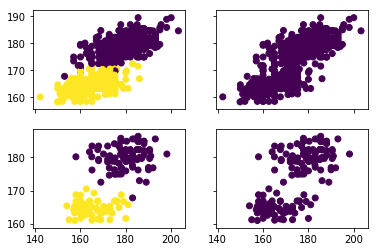

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:37:36<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 060b7f1c-a3e2-49ab-9bdb-4b5a01ee055e


          
  0% |          |[18:37:37<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 060b7f1c-a3e2-49ab-9bdb-4b5a01ee055e


          
  0% |          |[18:37:37<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  108.83% /s] 
  0% |          |[18:37:37<?]  ?% /s] 
100% |██████████|[00:00<00:00]  108.83% /s] 


CrowdAI.Event.Job.INFO : (060b7f1c-a3e2-49ab-9bdb-4b5a01ee055e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.305878515363 ; MSE : 70.5609074128
CrowdAI.Event.Job.COMPLETE : 060b7f1c-a3e2-49ab-9bdb-4b5a01ee055e	   🍺 


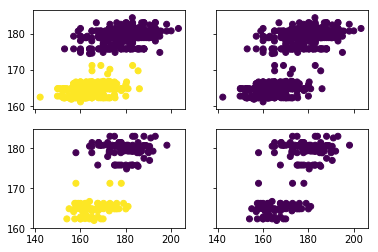

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[18:37:41<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 6db49e0e-e4c8-433d-8eaf-c1877fca68b0


          
  0% |          |[18:37:41<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 6db49e0e-e4c8-433d-8eaf-c1877fca68b0


          
  0% |          |[18:37:41<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 
          ██████|[00:00<00:00]  107.54% /s] 
  0% |          |[18:37:41<?]  ?% /s] 
100% |██████████|[00:00<00:00]  107.54% /s] 


CrowdAI.Event.Job.INFO : (6db49e0e-e4c8-433d-8eaf-c1877fca68b0) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.372527181691 ; MSE : 63.7857383998
CrowdAI.Event.Job.COMPLETE : 6db49e0e-e4c8-433d-8eaf-c1877fca68b0	   🍺 


In [183]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
rf_os = topsnp_model(m=m,X=X.iloc[2747:3530,],y=y.iloc[2747:3530,],df_test=df_test,val_idx=os_val_idx)

## 2.3 NN model with os data

# 3. TZ DATA

## 3.1 Linear Model with tz data

### Sample seperation of tz data

2747 2197


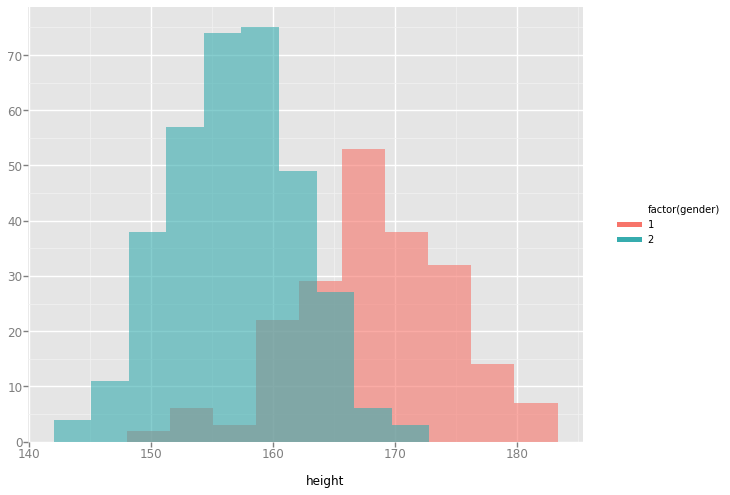

<ggplot: (-9223363276567651738)>

In [340]:
tz_meta = all_meta.iloc[0:2747,]
samp_size=len(tz_meta)
train_ratio = 0.8
train_size = int(samp_size * train_ratio)

import random
tz_val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
ggplot( aes(x='height',fill='factor(gender)'),data=tz_meta.iloc[tz_val_idx,]) +\
    geom_histogram(alpha=0.6)

### 3.1.1 Linear Model with tz data by top 10000, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10 snps

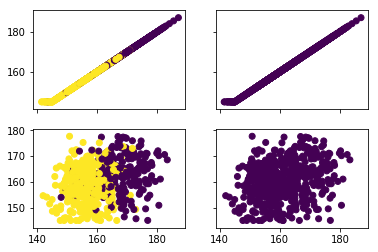

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3134ea49-d798-4f5f-a49e-fcd92596d553


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3134ea49-d798-4f5f-a49e-fcd92596d553


100% |██████████|[00:00<00:00]  111.10% /s] 


CrowdAI.Event.Job.INFO : (3134ea49-d798-4f5f-a49e-fcd92596d553) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.32594830372 ; MSE : 338.099216798
CrowdAI.Event.Job.COMPLETE : 3134ea49-d798-4f5f-a49e-fcd92596d553	   🍺 


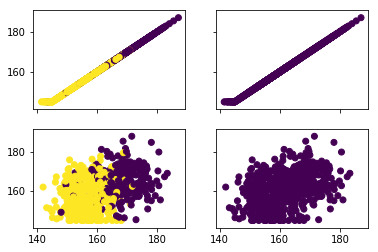

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : cf9ddbc9-3157-442d-8847-df7ca48d9059


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : cf9ddbc9-3157-442d-8847-df7ca48d9059


100% |██████████|[00:00<00:00]  111.00% /s] 


CrowdAI.Event.Job.INFO : (cf9ddbc9-3157-442d-8847-df7ca48d9059) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -1.65874846641 ; MSE : 270.275028974
CrowdAI.Event.Job.COMPLETE : cf9ddbc9-3157-442d-8847-df7ca48d9059	   🍺 


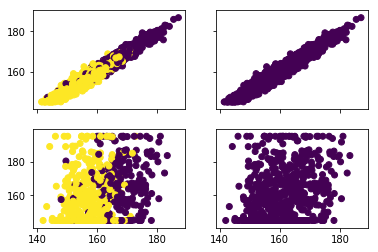

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3ae019ef-d0c4-4775-93ce-c66268180081


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3ae019ef-d0c4-4775-93ce-c66268180081


100% |██████████|[00:00<00:00]  107.02% /s] 


CrowdAI.Event.Job.INFO : (3ae019ef-d0c4-4775-93ce-c66268180081) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -3.3802308653 ; MSE : 445.272292205
CrowdAI.Event.Job.COMPLETE : 3ae019ef-d0c4-4775-93ce-c66268180081	   🍺 


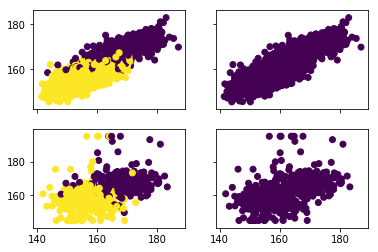

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ae28c53f-2364-41f9-9b43-b7ea9d0da3a2


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ae28c53f-2364-41f9-9b43-b7ea9d0da3a2


100% |██████████|[00:00<00:00]  108.31% /s] 


CrowdAI.Event.Job.INFO : (ae28c53f-2364-41f9-9b43-b7ea9d0da3a2) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.974200612505 ; MSE : 200.687328827
CrowdAI.Event.Job.COMPLETE : ae28c53f-2364-41f9-9b43-b7ea9d0da3a2	   🍺 


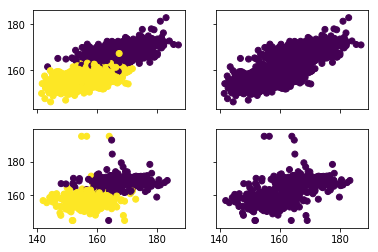

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : a59ed4fa-8934-404c-b32d-a9e097feff7c


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : a59ed4fa-8934-404c-b32d-a9e097feff7c


100% |██████████|[00:00<00:00]  104.97% /s] 


CrowdAI.Event.Job.INFO : (a59ed4fa-8934-404c-b32d-a9e097feff7c) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -1.65119168622 ; MSE : 269.506844616
CrowdAI.Event.Job.COMPLETE : a59ed4fa-8934-404c-b32d-a9e097feff7c	   🍺 


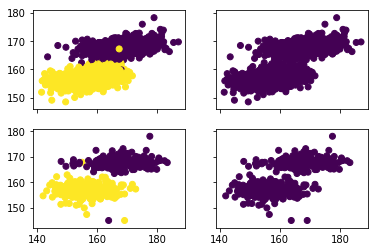

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d50a5d3b-780d-4ece-8fb1-7de274a2c821


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d50a5d3b-780d-4ece-8fb1-7de274a2c821


100% |██████████|[00:00<00:00]  107.87% /s] 


CrowdAI.Event.Job.INFO : (d50a5d3b-780d-4ece-8fb1-7de274a2c821) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.56790524588 ; MSE : 159.38538042
CrowdAI.Event.Job.COMPLETE : d50a5d3b-780d-4ece-8fb1-7de274a2c821	   🍺 


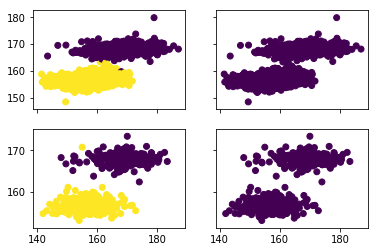

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3aacd1d7-f8bd-42e8-ab2b-ac00012aefd8


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3aacd1d7-f8bd-42e8-ab2b-ac00012aefd8


100% |██████████|[00:00<00:00]  106.61% /s] 


CrowdAI.Event.Job.INFO : (3aacd1d7-f8bd-42e8-ab2b-ac00012aefd8) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.416620648597 ; MSE : 144.006547322
CrowdAI.Event.Job.COMPLETE : 3aacd1d7-f8bd-42e8-ab2b-ac00012aefd8	   🍺 


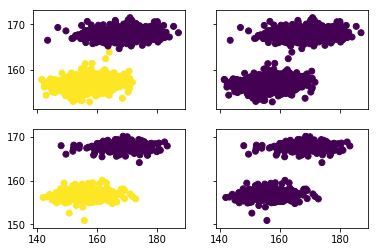

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 39898ecf-41bf-4166-828b-3c6fa7f0caf2


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 39898ecf-41bf-4166-828b-3c6fa7f0caf2


100% |██████████|[00:00<00:00]  104.68% /s] 


CrowdAI.Event.Job.INFO : (39898ecf-41bf-4166-828b-3c6fa7f0caf2) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.420376252695 ; MSE : 144.388323191
CrowdAI.Event.Job.COMPLETE : 39898ecf-41bf-4166-828b-3c6fa7f0caf2	   🍺 


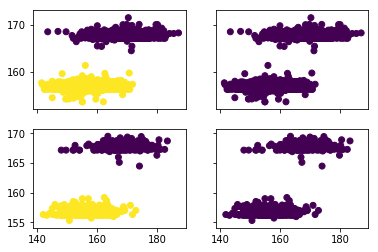

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3db1c4f3-bfd7-4cb1-b705-7630b304cc3b


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3db1c4f3-bfd7-4cb1-b705-7630b304cc3b


100% |██████████|[00:00<00:00]  106.65% /s] 


CrowdAI.Event.Job.INFO : (3db1c4f3-bfd7-4cb1-b705-7630b304cc3b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.622551291627 ; MSE : 164.940423247
CrowdAI.Event.Job.COMPLETE : 3db1c4f3-bfd7-4cb1-b705-7630b304cc3b	   🍺 


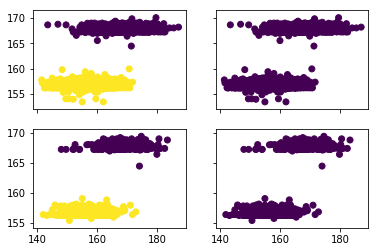

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bb8c0b90-71a8-412c-9043-1e42fa35b679


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bb8c0b90-71a8-412c-9043-1e42fa35b679


100% |██████████|[00:00<00:00]  106.60% /s] 


CrowdAI.Event.Job.INFO : (bb8c0b90-71a8-412c-9043-1e42fa35b679) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.631400246751 ; MSE : 165.839963626
CrowdAI.Event.Job.COMPLETE : bb8c0b90-71a8-412c-9043-1e42fa35b679	   🍺 


In [342]:
lm_tz = topsnp_model(m=linear_model.LinearRegression(),X=X.iloc[0:2747,],y=y.iloc[0:2747,],df_test=df_test,val_idx=tz_val_idx)

### 3.1.2 Residual Model with tz data by top 10000, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10 snps

In [344]:
#Load training data
x_train = X.iloc[0:2747,]
x_train = x_train[['gender','nationality']]
y_train = y.iloc[0:2747,]
x_test = df_test[['gender','nationality']]

# Instantiate a linear model
tz_gender_nation_ml = linear_model.LinearRegression()
tz_gender_nation_ml.fit(x_train, y_train)

# Predict the heights for the test set
heights = tz_gender_nation_ml.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 7efdecba-32a5-4e24-b3d3-dd78e773f16a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 7efdecba-32a5-4e24-b3d3-dd78e773f16a


100% |██████████|[00:00<00:00]  105.79% /s] 


CrowdAI.Event.Job.INFO : (7efdecba-32a5-4e24-b3d3-dd78e773f16a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.66946943213 ; MSE : 169.709886001
CrowdAI.Event.Job.COMPLETE : 7efdecba-32a5-4e24-b3d3-dd78e773f16a	   🍺 


(array([  2.,   8.,  56., 204., 610., 828., 642., 312.,  77.,   8.]),
 array([-24.40627, -20.05627, -15.70627, -11.35627,  -7.00627,  -2.65627,   1.69373,   6.04373,  10.39373,
         14.74373,  19.09373]),
 <a list of 10 Patch objects>)

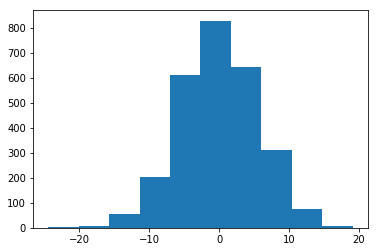

In [345]:
plt.hist(y_train-tz_gender_nation_ml.predict(x_train))

In [346]:
y_residual=y_train-tz_gender_nation_ml.predict(x_train)

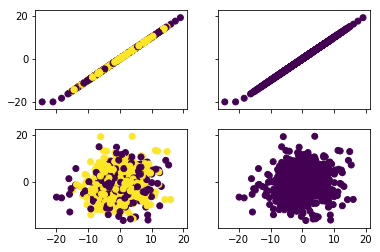

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 904ca390-17a6-47ce-a01e-71fee2240b9e


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 904ca390-17a6-47ce-a01e-71fee2240b9e


100% |██████████|[00:00<00:00]  108.48% /s] 


CrowdAI.Event.Job.INFO : (904ca390-17a6-47ce-a01e-71fee2240b9e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.175717714541 ; MSE : 119.517563763
CrowdAI.Event.Job.COMPLETE : 904ca390-17a6-47ce-a01e-71fee2240b9e	   🍺 


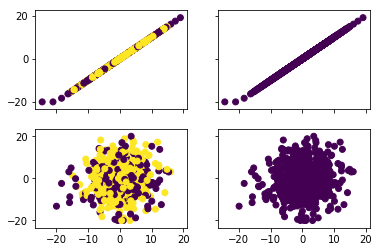

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d7968ee9-684b-4350-8503-d924b3a58b9c


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d7968ee9-684b-4350-8503-d924b3a58b9c


100% |██████████|[00:00<00:00]  110.28% /s] 


CrowdAI.Event.Job.INFO : (d7968ee9-684b-4350-8503-d924b3a58b9c) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.220210033588 ; MSE : 124.040429679
CrowdAI.Event.Job.COMPLETE : d7968ee9-684b-4350-8503-d924b3a58b9c	   🍺 


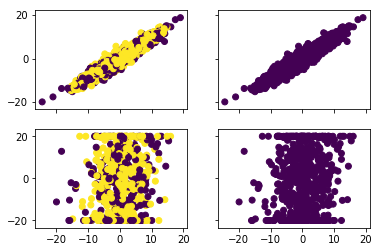

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bdd58fb5-ea94-47af-be10-8d57cd3c6b00


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bdd58fb5-ea94-47af-be10-8d57cd3c6b00


100% |██████████|[00:00<00:00]  110.94% /s] 


CrowdAI.Event.Job.INFO : (bdd58fb5-ea94-47af-be10-8d57cd3c6b00) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.40001708787 ; MSE : 345.628677759
CrowdAI.Event.Job.COMPLETE : bdd58fb5-ea94-47af-be10-8d57cd3c6b00	   🍺 


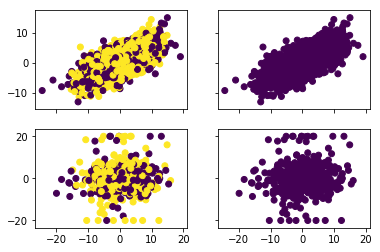

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 37ab9330-0f4e-4bfb-83b7-9f22a3d9850e


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 37ab9330-0f4e-4bfb-83b7-9f22a3d9850e


100% |██████████|[00:00<00:00]  105.10% /s] 


CrowdAI.Event.Job.INFO : (37ab9330-0f4e-4bfb-83b7-9f22a3d9850e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.807814650007 ; MSE : 183.773366712
CrowdAI.Event.Job.COMPLETE : 37ab9330-0f4e-4bfb-83b7-9f22a3d9850e	   🍺 


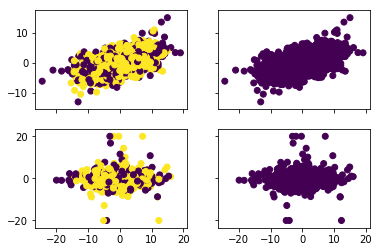

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : efc5c7e6-7bf3-4ef8-8ad6-9f506840f7b8


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : efc5c7e6-7bf3-4ef8-8ad6-9f506840f7b8


100% |██████████|[00:00<00:00]  106.00% /s] 


CrowdAI.Event.Job.INFO : (efc5c7e6-7bf3-4ef8-8ad6-9f506840f7b8) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.530334815903 ; MSE : 155.566159016
CrowdAI.Event.Job.COMPLETE : efc5c7e6-7bf3-4ef8-8ad6-9f506840f7b8	   🍺 


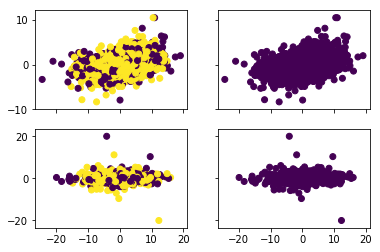

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : b9e6f817-7054-47cd-94fe-d55542655f9f


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : b9e6f817-7054-47cd-94fe-d55542655f9f


100% |██████████|[00:00<00:00]  107.05% /s] 


CrowdAI.Event.Job.INFO : (b9e6f817-7054-47cd-94fe-d55542655f9f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.350375841861 ; MSE : 66.0375324638
CrowdAI.Event.Job.COMPLETE : b9e6f817-7054-47cd-94fe-d55542655f9f	   🍺 


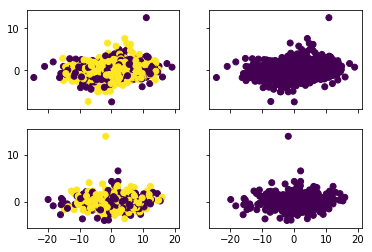

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : b2279d09-ade8-42e5-9f2d-2d4e50d5992f


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : b2279d09-ade8-42e5-9f2d-2d4e50d5992f


100% |██████████|[00:00<00:00]  109.05% /s] 


CrowdAI.Event.Job.INFO : (b2279d09-ade8-42e5-9f2d-2d4e50d5992f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.412997483156 ; MSE : 59.6717306103
CrowdAI.Event.Job.COMPLETE : b2279d09-ade8-42e5-9f2d-2d4e50d5992f	   🍺 


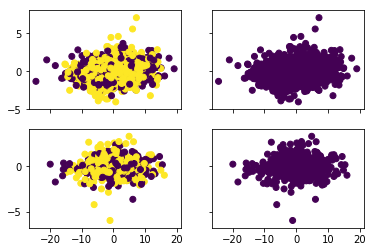

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 1b0ed913-0c71-4b55-9317-7890354fa5a8


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 1b0ed913-0c71-4b55-9317-7890354fa5a8


100% |██████████|[00:00<00:00]  106.39% /s] 


CrowdAI.Event.Job.INFO : (1b0ed913-0c71-4b55-9317-7890354fa5a8) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.41440761596 ; MSE : 59.5283835847
CrowdAI.Event.Job.COMPLETE : 1b0ed913-0c71-4b55-9317-7890354fa5a8	   🍺 


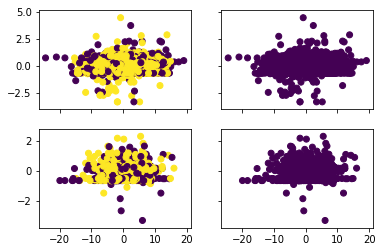

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 77d1159a-37bf-405e-8d93-d66e3838be21


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 77d1159a-37bf-405e-8d93-d66e3838be21


100% |██████████|[00:01<00:00]  96.16% /s] 


CrowdAI.Event.Job.INFO : (77d1159a-37bf-405e-8d93-d66e3838be21) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.416958622914 ; MSE : 59.2690610173
CrowdAI.Event.Job.COMPLETE : 77d1159a-37bf-405e-8d93-d66e3838be21	   🍺 


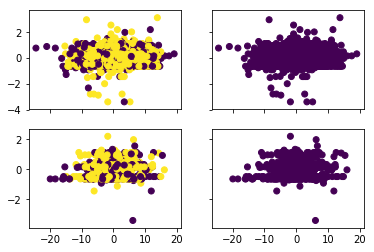

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 05a3ed95-09da-44ab-b1f7-0e299f8c432d


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 05a3ed95-09da-44ab-b1f7-0e299f8c432d


100% |██████████|[00:00<00:00]  107.39% /s] 


CrowdAI.Event.Job.INFO : (05a3ed95-09da-44ab-b1f7-0e299f8c432d) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.422408504631 ; MSE : 58.7150533865
CrowdAI.Event.Job.COMPLETE : 05a3ed95-09da-44ab-b1f7-0e299f8c432d	   🍺 


In [347]:
lm_tz_res = topsnp_model(m=linear_model.LinearRegression(),X=X.iloc[0:2747,],y=y_residual,df_test=df_test,val_idx=tz_val_idx,residual=True)

In [348]:
lm_tz_res[0]

{7726: (1.0, -0.9623036136539065),
 5000: (1.0, -1.6218816189869099),
 2000: (0.9162506657740325, -4.607679346429234e+20),
 1000: (0.4677924364013135, -1.334793197765699e+22),
 500: (0.24155699300094732, -9.3486778145369e+20),
 200: (0.10858687258171984, -4.2373254841096387e+21),
 100: (0.04201527286441442, -0.0543317424730152),
 50: (0.03082678860116406, -0.026031303541691697),
 20: (0.012430273995367336, 0.0005834555686271559),
 10: (0.010633354396903938, 0.0038130173126311724)}

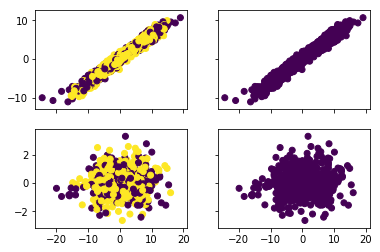

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d7429554-5fa3-4fa4-b093-38dfe7350601


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d7429554-5fa3-4fa4-b093-38dfe7350601


100% |██████████|[00:00<00:00]  107.64% /s] 


CrowdAI.Event.Job.INFO : (d7429554-5fa3-4fa4-b093-38dfe7350601) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.432892985965 ; MSE : 57.6492536193
CrowdAI.Event.Job.COMPLETE : d7429554-5fa3-4fa4-b093-38dfe7350601	   🍺 


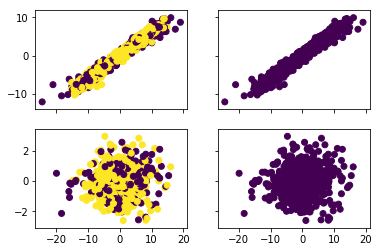

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 451d2e28-c586-4685-a594-b10a213defa7


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 451d2e28-c586-4685-a594-b10a213defa7


100% |██████████|[00:00<00:00]  108.35% /s] 


CrowdAI.Event.Job.INFO : (451d2e28-c586-4685-a594-b10a213defa7) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.412347596304 ; MSE : 59.7377948469
CrowdAI.Event.Job.COMPLETE : 451d2e28-c586-4685-a594-b10a213defa7	   🍺 


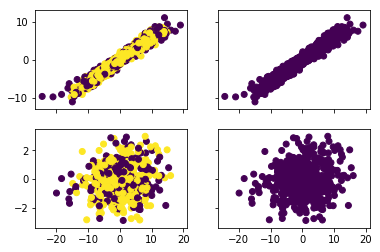

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 2f73816f-990e-4f4b-aba1-16202e0c1de0


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 2f73816f-990e-4f4b-aba1-16202e0c1de0


100% |██████████|[00:00<00:00]  105.85% /s] 


CrowdAI.Event.Job.INFO : (2f73816f-990e-4f4b-aba1-16202e0c1de0) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.409860768122 ; MSE : 59.9905933223
CrowdAI.Event.Job.COMPLETE : 2f73816f-990e-4f4b-aba1-16202e0c1de0	   🍺 


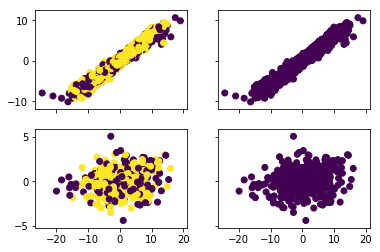

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 302a2421-a98a-4226-ad5a-39976ab81212


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 302a2421-a98a-4226-ad5a-39976ab81212


100% |██████████|[00:00<00:00]  108.16% /s] 


CrowdAI.Event.Job.INFO : (302a2421-a98a-4226-ad5a-39976ab81212) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.422188120428 ; MSE : 58.7374565388
CrowdAI.Event.Job.COMPLETE : 302a2421-a98a-4226-ad5a-39976ab81212	   🍺 


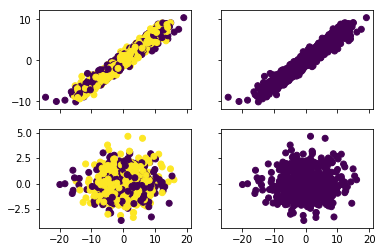

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 43cfee4a-5837-43ec-8a67-807485b9e41c


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 43cfee4a-5837-43ec-8a67-807485b9e41c


100% |██████████|[00:00<00:00]  107.44% /s] 


CrowdAI.Event.Job.INFO : (43cfee4a-5837-43ec-8a67-807485b9e41c) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.406299755644 ; MSE : 60.3525879837
CrowdAI.Event.Job.COMPLETE : 43cfee4a-5837-43ec-8a67-807485b9e41c	   🍺 


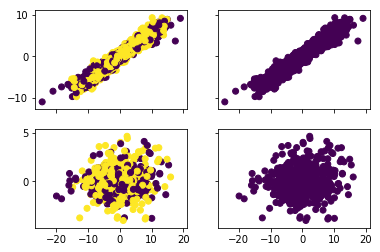

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 67d07807-1633-4696-8023-f836aa20869f


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 67d07807-1633-4696-8023-f836aa20869f


100% |██████████|[00:00<00:00]  102.84% /s] 


CrowdAI.Event.Job.INFO : (67d07807-1633-4696-8023-f836aa20869f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.410140400131 ; MSE : 59.9621673354
CrowdAI.Event.Job.COMPLETE : 67d07807-1633-4696-8023-f836aa20869f	   🍺 


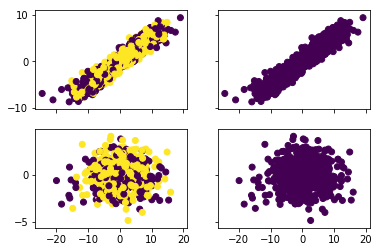

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 053b5e4b-1f20-42c7-bf5a-c2f9c7895edd


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 053b5e4b-1f20-42c7-bf5a-c2f9c7895edd


100% |██████████|[00:00<00:00]  107.97% /s] 


CrowdAI.Event.Job.INFO : (053b5e4b-1f20-42c7-bf5a-c2f9c7895edd) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.403035078204 ; MSE : 60.6844587119
CrowdAI.Event.Job.COMPLETE : 053b5e4b-1f20-42c7-bf5a-c2f9c7895edd	   🍺 


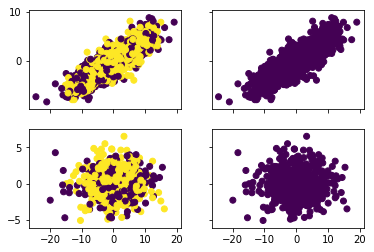

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bc3a149c-6aaf-4d01-987e-7cdff9c8728b


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bc3a149c-6aaf-4d01-987e-7cdff9c8728b


100% |██████████|[00:00<00:00]  107.85% /s] 


CrowdAI.Event.Job.INFO : (bc3a149c-6aaf-4d01-987e-7cdff9c8728b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.384640300249 ; MSE : 62.5543795441
CrowdAI.Event.Job.COMPLETE : bc3a149c-6aaf-4d01-987e-7cdff9c8728b	   🍺 


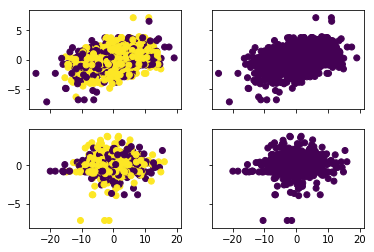

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : a9ab2673-cc56-461a-b514-caeff8359579


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : a9ab2673-cc56-461a-b514-caeff8359579


100% |██████████|[00:00<00:00]  109.13% /s] 


CrowdAI.Event.Job.INFO : (a9ab2673-cc56-461a-b514-caeff8359579) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.409777682224 ; MSE : 59.9990394179
CrowdAI.Event.Job.COMPLETE : a9ab2673-cc56-461a-b514-caeff8359579	   🍺 


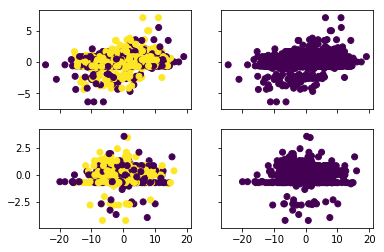

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 8323151f-a3ea-4078-b7c2-7c10c111b2ac


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 8323151f-a3ea-4078-b7c2-7c10c111b2ac


100% |██████████|[00:00<00:00]  105.46% /s] 


CrowdAI.Event.Job.INFO : (8323151f-a3ea-4078-b7c2-7c10c111b2ac) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.42947806525 ; MSE : 57.996397325
CrowdAI.Event.Job.COMPLETE : 8323151f-a3ea-4078-b7c2-7c10c111b2ac	   🍺 


In [349]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
rf_tz_res = topsnp_model(m=m,X=X.iloc[0:2747,],y=y_residual,df_test=df_test,val_idx=tz_val_idx,residual=True)

## 3.2 Random Forest with tz data

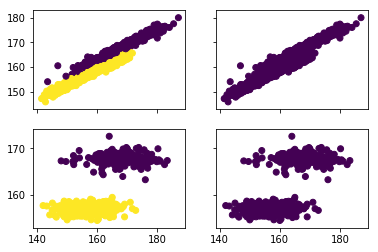

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Connection.CONNECTED
CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ed681d64-176b-4d89-b3d4-96fe5f8c11a3


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ed681d64-176b-4d89-b3d4-96fe5f8c11a3


100% |██████████|[00:00<00:00]  102.58% /s] 


CrowdAI.Event.Job.INFO : (ed681d64-176b-4d89-b3d4-96fe5f8c11a3) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.651270633356 ; MSE : 167.85988743
CrowdAI.Event.Job.COMPLETE : ed681d64-176b-4d89-b3d4-96fe5f8c11a3	   🍺 


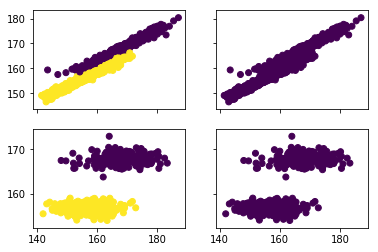

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : c0625866-12fe-4d90-8552-a216fbe4d1f6


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : c0625866-12fe-4d90-8552-a216fbe4d1f6


100% |██████████|[00:00<00:00]  106.41% /s] 


CrowdAI.Event.Job.INFO : (c0625866-12fe-4d90-8552-a216fbe4d1f6) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.594930950597 ; MSE : 162.132677961
CrowdAI.Event.Job.COMPLETE : c0625866-12fe-4d90-8552-a216fbe4d1f6	   🍺 


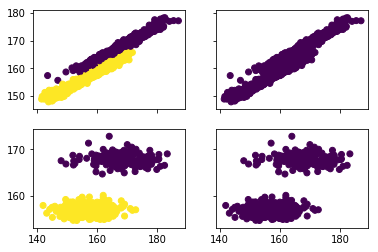

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 8c83df14-c48c-4ca1-983b-8d1e26b6152f


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 8c83df14-c48c-4ca1-983b-8d1e26b6152f


100% |██████████|[00:00<00:00]  106.68% /s] 


CrowdAI.Event.Job.INFO : (8c83df14-c48c-4ca1-983b-8d1e26b6152f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.647314761775 ; MSE : 167.457753373
CrowdAI.Event.Job.COMPLETE : 8c83df14-c48c-4ca1-983b-8d1e26b6152f	   🍺 


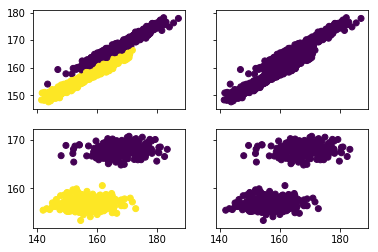

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 2cc8f5c9-d41a-4c99-a35b-af635f5b1169


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 2cc8f5c9-d41a-4c99-a35b-af635f5b1169


100% |██████████|[00:00<00:00]  100.23% /s] 


CrowdAI.Event.Job.INFO : (2cc8f5c9-d41a-4c99-a35b-af635f5b1169) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.722000381958 ; MSE : 175.04991879
CrowdAI.Event.Job.COMPLETE : 2cc8f5c9-d41a-4c99-a35b-af635f5b1169	   🍺 


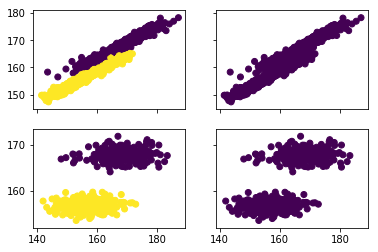

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 9f2b7a36-ceea-4a74-a55d-4ae751a1ea23


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 9f2b7a36-ceea-4a74-a55d-4ae751a1ea23


100% |██████████|[00:00<00:00]  107.66% /s] 


CrowdAI.Event.Job.INFO : (9f2b7a36-ceea-4a74-a55d-4ae751a1ea23) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.638326281373 ; MSE : 166.544029555
CrowdAI.Event.Job.COMPLETE : 9f2b7a36-ceea-4a74-a55d-4ae751a1ea23	   🍺 


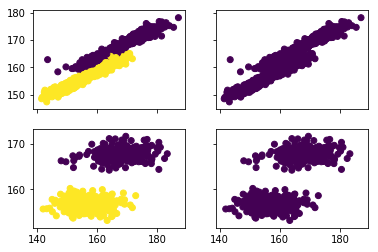

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ef070551-e21f-4c8e-b740-fe614c91c601


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ef070551-e21f-4c8e-b740-fe614c91c601


100% |██████████|[00:00<00:00]  106.90% /s] 


CrowdAI.Event.Job.INFO : (ef070551-e21f-4c8e-b740-fe614c91c601) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.6843958048 ; MSE : 171.227226155
CrowdAI.Event.Job.COMPLETE : ef070551-e21f-4c8e-b740-fe614c91c601	   🍺 


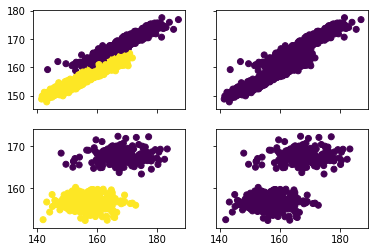

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 4cac4743-22c9-40fc-8487-df11dbe8729f


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 4cac4743-22c9-40fc-8487-df11dbe8729f


100% |██████████|[00:00<00:00]  105.35% /s] 


CrowdAI.Event.Job.INFO : (4cac4743-22c9-40fc-8487-df11dbe8729f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.640375315109 ; MSE : 166.752324043
CrowdAI.Event.Job.COMPLETE : 4cac4743-22c9-40fc-8487-df11dbe8729f	   🍺 


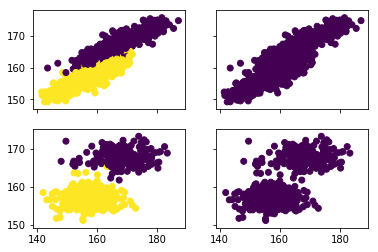

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 73eec3a1-cebb-4a07-a26d-c6084ca3f511


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 73eec3a1-cebb-4a07-a26d-c6084ca3f511


100% |██████████|[00:00<00:00]  106.98% /s] 


CrowdAI.Event.Job.INFO : (73eec3a1-cebb-4a07-a26d-c6084ca3f511) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.614963992381 ; MSE : 164.169136475
CrowdAI.Event.Job.COMPLETE : 73eec3a1-cebb-4a07-a26d-c6084ca3f511	   🍺 


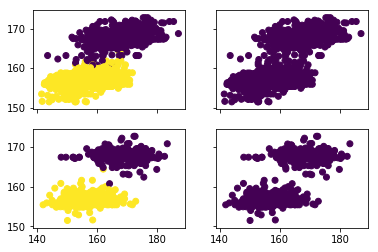

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : f4d6a187-423c-4780-b63e-4c3140e50a1e


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : f4d6a187-423c-4780-b63e-4c3140e50a1e


100% |██████████|[00:00<00:00]  101.33% /s] 


CrowdAI.Event.Job.INFO : (f4d6a187-423c-4780-b63e-4c3140e50a1e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.669432310805 ; MSE : 169.706112434
CrowdAI.Event.Job.COMPLETE : f4d6a187-423c-4780-b63e-4c3140e50a1e	   🍺 


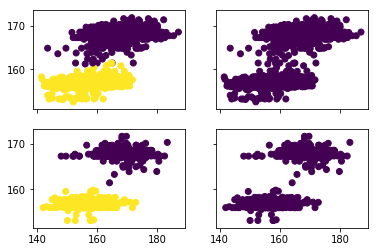

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 7bb6da57-22e9-4177-8c93-7178db77d5c5


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 7bb6da57-22e9-4177-8c93-7178db77d5c5


100% |██████████|[00:00<00:00]  102.28% /s] 


CrowdAI.Event.Job.INFO : (7bb6da57-22e9-4177-8c93-7178db77d5c5) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.620139691473 ; MSE : 164.695272076
CrowdAI.Event.Job.COMPLETE : 7bb6da57-22e9-4177-8c93-7178db77d5c5	   🍺 


In [351]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
rf_tz = topsnp_model(m=m,X=X.iloc[0:2747,],y=y.iloc[0:2747,],df_test=df_test,val_idx=tz_val_idx)

In [352]:
rf_tz[0]

{7726: (0.9130616592492592, 0.475471828003499),
 5000: (0.9124809436304251, 0.48488068959179076),
 2000: (0.9101848972693694, 0.4690624900349124),
 1000: (0.9074244771162757, 0.4804392117072688),
 500: (0.9046918603111446, 0.48294912007481755),
 200: (0.8890371840464301, 0.47752630360984333),
 100: (0.873026759878836, 0.4557303060039193),
 50: (0.8056156815810166, 0.43347376313616215),
 20: (0.5343511399253469, 0.4667554512909726),
 10: (0.49938197344667734, 0.4772599076587596)}

# 4. TZ Female DATA

## 4.1 Linear Model with tz_f data

### Sample seperation of tz_f data

In [ ]:
tz_meta = all_meta.iloc[0:2747,]

In [363]:
tz_f_idx=list(np.logical_and(all_meta.gender==2,all_meta.nationality!='PROBLEM'))

1758 1406


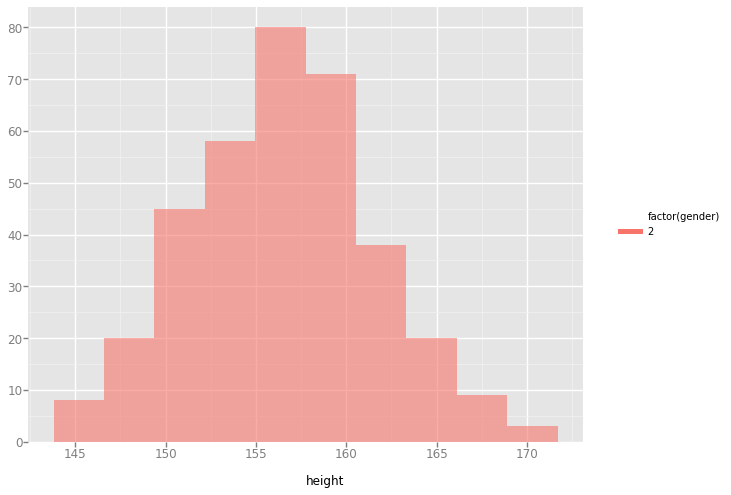

<ggplot: (-9223363276568423266)>

In [357]:
tz_f_meta = tz_meta.loc[tz_meta.gender==2]
samp_size=len(tz_f_meta)
train_ratio = 0.8
train_size = int(samp_size * train_ratio)

import random
tz_val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
ggplot( aes(x='height',fill='factor(gender)'),data=tz_f_meta.iloc[tz_val_idx,]) +\
    geom_histogram(alpha=0.6)

### 4.1.1 Linear Model with tz_f data by top 10000, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10 snps

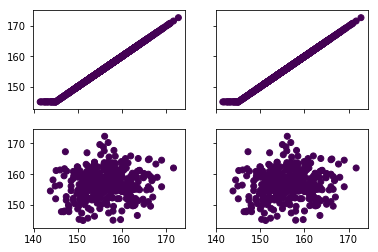

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 80fff6c8-5bdd-4294-aafa-1c70a5683ff2


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 80fff6c8-5bdd-4294-aafa-1c70a5683ff2


100% |██████████|[00:00<00:00]  102.06% /s] 


CrowdAI.Event.Job.INFO : (80fff6c8-5bdd-4294-aafa-1c70a5683ff2) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -4.45264673407 ; MSE : 554.288708638
CrowdAI.Event.Job.COMPLETE : 80fff6c8-5bdd-4294-aafa-1c70a5683ff2	   🍺 


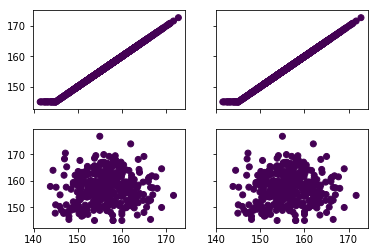

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : be7036d2-e564-4eb9-865c-0f5d649d9c2b


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : be7036d2-e564-4eb9-865c-0f5d649d9c2b


100% |██████████|[00:00<00:00]  101.55% /s] 


CrowdAI.Event.Job.INFO : (be7036d2-e564-4eb9-865c-0f5d649d9c2b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -4.54082779809 ; MSE : 563.252753162
CrowdAI.Event.Job.COMPLETE : be7036d2-e564-4eb9-865c-0f5d649d9c2b	   🍺 


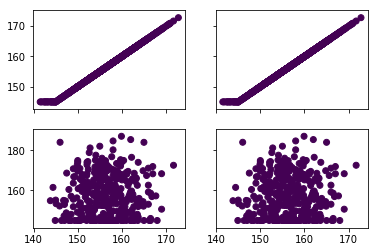

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 05bf87bc-dd60-48fb-8605-1582484fac88


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 05bf87bc-dd60-48fb-8605-1582484fac88


100% |██████████|[00:00<00:00]  109.39% /s] 


CrowdAI.Event.Job.INFO : (05bf87bc-dd60-48fb-8605-1582484fac88) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -4.55215629355 ; MSE : 564.404351171
CrowdAI.Event.Job.COMPLETE : 05bf87bc-dd60-48fb-8605-1582484fac88	   🍺 


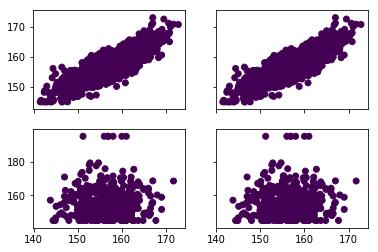

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : c3bc1dc4-4d70-4fe3-b634-d88f2b97607f


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : c3bc1dc4-4d70-4fe3-b634-d88f2b97607f


100% |██████████|[00:00<00:00]  109.45% /s] 


CrowdAI.Event.Job.INFO : (c3bc1dc4-4d70-4fe3-b634-d88f2b97607f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -4.63974821475 ; MSE : 573.308506392
CrowdAI.Event.Job.COMPLETE : c3bc1dc4-4d70-4fe3-b634-d88f2b97607f	   🍺 


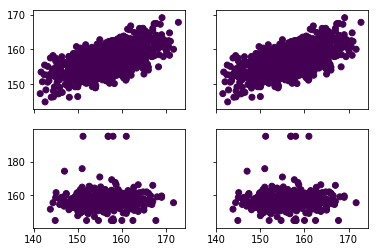

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 6c6de5c4-1a21-4f9c-b1af-5c74954ff5dd


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 6c6de5c4-1a21-4f9c-b1af-5c74954ff5dd


100% |██████████|[00:00<00:00]  107.76% /s] 


CrowdAI.Event.Job.INFO : (6c6de5c4-1a21-4f9c-b1af-5c74954ff5dd) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -4.26907482953 ; MSE : 535.627709884
CrowdAI.Event.Job.COMPLETE : 6c6de5c4-1a21-4f9c-b1af-5c74954ff5dd	   🍺 


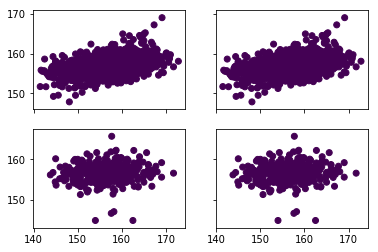

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 9af30679-a460-4e40-8fa8-0f1560543705


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 9af30679-a460-4e40-8fa8-0f1560543705


100% |██████████|[00:00<00:00]  107.53% /s] 


CrowdAI.Event.Job.INFO : (9af30679-a460-4e40-8fa8-0f1560543705) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -3.93523061049 ; MSE : 501.690781621
CrowdAI.Event.Job.COMPLETE : 9af30679-a460-4e40-8fa8-0f1560543705	   🍺 


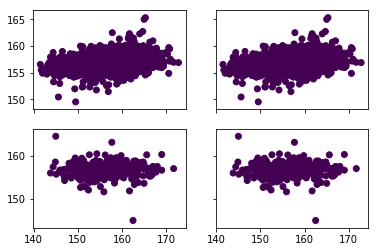

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 7c9cce89-979c-4a28-a26b-2d3a90346346


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 7c9cce89-979c-4a28-a26b-2d3a90346346


100% |██████████|[00:00<00:00]  107.67% /s] 


CrowdAI.Event.Job.INFO : (7c9cce89-979c-4a28-a26b-2d3a90346346) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -3.55074807559 ; MSE : 462.606216242
CrowdAI.Event.Job.COMPLETE : 7c9cce89-979c-4a28-a26b-2d3a90346346	   🍺 


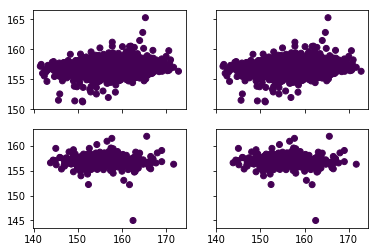

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d2c5928b-703f-4418-bd6d-7a0be2b4b93a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d2c5928b-703f-4418-bd6d-7a0be2b4b93a


100% |██████████|[00:00<00:00]  106.54% /s] 


CrowdAI.Event.Job.INFO : (d2c5928b-703f-4418-bd6d-7a0be2b4b93a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.34715961218 ; MSE : 340.25545199
CrowdAI.Event.Job.COMPLETE : d2c5928b-703f-4418-bd6d-7a0be2b4b93a	   🍺 


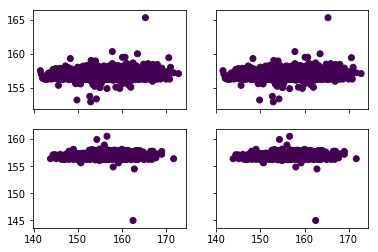

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ab46efbb-fb0d-4e5e-8917-f830d811a15c


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ab46efbb-fb0d-4e5e-8917-f830d811a15c


100% |██████████|[00:00<00:00]  105.63% /s] 


CrowdAI.Event.Job.INFO : (ab46efbb-fb0d-4e5e-8917-f830d811a15c) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.59621010441 ; MSE : 365.572675433
CrowdAI.Event.Job.COMPLETE : ab46efbb-fb0d-4e5e-8917-f830d811a15c	   🍺 


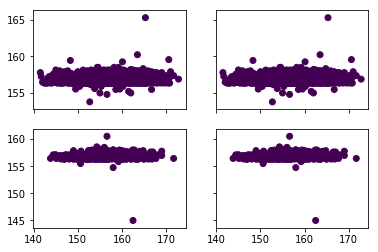

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 6c297db7-59ee-4abb-a759-fcc8d063f082


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 6c297db7-59ee-4abb-a759-fcc8d063f082


100% |██████████|[00:00<00:00]  108.77% /s] 


CrowdAI.Event.Job.INFO : (6c297db7-59ee-4abb-a759-fcc8d063f082) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.6661537509 ; MSE : 372.682795597
CrowdAI.Event.Job.COMPLETE : 6c297db7-59ee-4abb-a759-fcc8d063f082	   🍺 


In [365]:
lm_tz_f = topsnp_model(m=linear_model.LinearRegression(),X=X.loc[tz_f_idx,],y=y.loc[tz_f_idx,],df_test=df_test,val_idx=tz_val_idx)

In [366]:
lm_tz_f[0]

{7726: (1.0, -0.6888778230530832),
 5000: (1.0, -1.2080313628758872),
 2000: (1.0, -5.45794611237993),
 1000: (0.7371201831678995, -1.4447333845069694e+21),
 500: (0.3818825308367474, -5.915422992225212e+16),
 200: (0.16008629852344125, -0.23424909848849418),
 100: (0.07844382394622917, -0.14987183136593596),
 50: (0.04083149128875574, -0.1186491848140745),
 20: (0.015886379072032386, -0.09979499354650034),
 10: (0.012396679530405685, -0.08985872172460563)}

### 4.1.2 Residual Model with tz_f data by top 10000, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10 snps

In [367]:
#Load training data
x_train = X.loc[tz_f_idx,]
x_train = x_train[['gender','nationality']]
y_train = y.loc[tz_f_idx,]
x_test = df_test[['gender','nationality']]

# Instantiate a linear model
tz_gender_nation_ml = linear_model.LinearRegression()
tz_gender_nation_ml.fit(x_train, y_train)

# Predict the heights for the test set
heights = tz_gender_nation_ml.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 1a1e342b-210d-491e-8db1-832dfa6f050e


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 1a1e342b-210d-491e-8db1-832dfa6f050e


100% |██████████|[00:00<00:00]  107.02% /s] 


CrowdAI.Event.Job.INFO : (1a1e342b-210d-491e-8db1-832dfa6f050e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.78363563645 ; MSE : 384.625414623
CrowdAI.Event.Job.COMPLETE : 1a1e342b-210d-491e-8db1-832dfa6f050e	   🍺 


(array([ 22.,  58., 140., 314., 409., 370., 248., 143.,  43.,  11.]),
 array([-15.29295, -12.16295,  -9.03295,  -5.90295,  -2.77295,   0.35705,   3.48705,   6.61705,   9.74705,
         12.87705,  16.00705]),
 <a list of 10 Patch objects>)

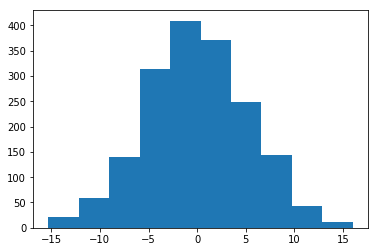

In [368]:
plt.hist(y_train-tz_gender_nation_ml.predict(x_train))

In [372]:
y_residual=y_train-tz_gender_nation_ml.predict(x_train)

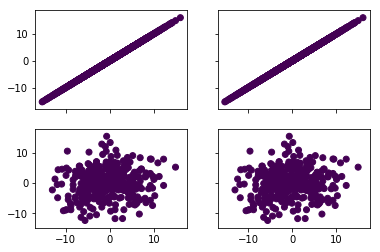

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ae5c78d2-5491-42ef-b0db-43b3bdf79e2b


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ae5c78d2-5491-42ef-b0db-43b3bdf79e2b


100% |██████████|[00:00<00:00]  105.86% /s] 


CrowdAI.Event.Job.INFO : (ae5c78d2-5491-42ef-b0db-43b3bdf79e2b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.0487812489248 ; MSE : 106.613839565
CrowdAI.Event.Job.COMPLETE : ae5c78d2-5491-42ef-b0db-43b3bdf79e2b	   🍺 


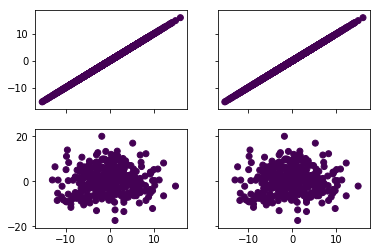

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 583cbce9-41ab-4f4f-9003-3d0b66e164be


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 583cbce9-41ab-4f4f-9003-3d0b66e164be


100% |██████████|[00:00<00:00]  108.62% /s] 


CrowdAI.Event.Job.INFO : (583cbce9-41ab-4f4f-9003-3d0b66e164be) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.264162193578 ; MSE : 128.508385737
CrowdAI.Event.Job.COMPLETE : 583cbce9-41ab-4f4f-9003-3d0b66e164be	   🍺 


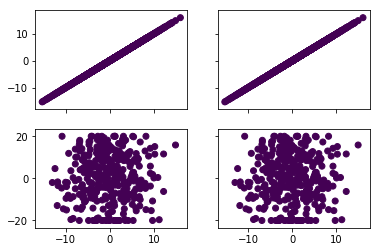

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : f371123d-10e2-4f62-9e7f-8bd6beaa618c
CrowdAI.Event.Job.RUNNING : f371123d-10e2-4f62-9e7f-8bd6beaa618c


100% |██████████|[00:01<00:00]  91.66% /s] 


CrowdAI.Event.Job.INFO : (f371123d-10e2-4f62-9e7f-8bd6beaa618c) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.984598688486 ; MSE : 201.744345059
CrowdAI.Event.Job.COMPLETE : f371123d-10e2-4f62-9e7f-8bd6beaa618c	   🍺 


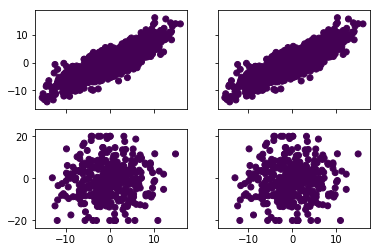

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3f58b4a5-df50-4c11-9b8d-c50706a59140


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3f58b4a5-df50-4c11-9b8d-c50706a59140


100% |██████████|[00:00<00:00]  102.28% /s] 


CrowdAI.Event.Job.INFO : (3f58b4a5-df50-4c11-9b8d-c50706a59140) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.00698437944 ; MSE : 305.674944639
CrowdAI.Event.Job.COMPLETE : 3f58b4a5-df50-4c11-9b8d-c50706a59140	   🍺 


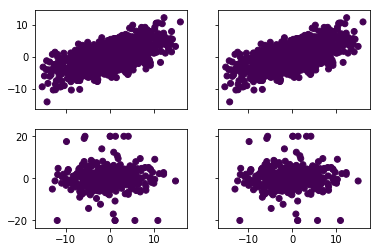

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 7e69caf5-7bc2-4b90-950d-bd870f373fb0


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 7e69caf5-7bc2-4b90-950d-bd870f373fb0


100% |██████████|[00:00<00:00]  110.79% /s] 


CrowdAI.Event.Job.INFO : (7e69caf5-7bc2-4b90-950d-bd870f373fb0) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -1.47979694831 ; MSE : 252.083715523
CrowdAI.Event.Job.COMPLETE : 7e69caf5-7bc2-4b90-950d-bd870f373fb0	   🍺 


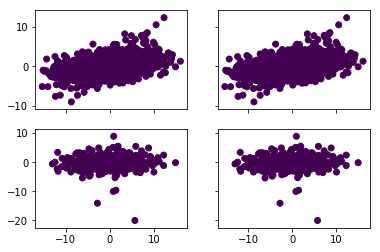

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : acd104ac-2ac5-478c-bd09-fcd6b49d3838


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : acd104ac-2ac5-478c-bd09-fcd6b49d3838


100% |██████████|[00:00<00:00]  104.81% /s] 


CrowdAI.Event.Job.INFO : (acd104ac-2ac5-478c-bd09-fcd6b49d3838) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.483354400036 ; MSE : 150.790365661
CrowdAI.Event.Job.COMPLETE : acd104ac-2ac5-478c-bd09-fcd6b49d3838	   🍺 


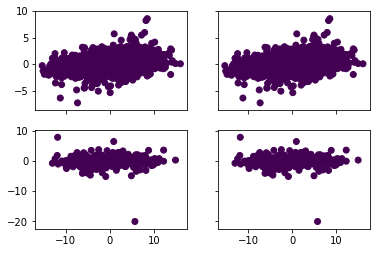

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : cb61bd9d-f027-4678-bcf4-2cefee719145


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : cb61bd9d-f027-4678-bcf4-2cefee719145


100% |██████████|[00:00<00:00]  109.50% /s] 


CrowdAI.Event.Job.INFO : (cb61bd9d-f027-4678-bcf4-2cefee719145) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.209163583947 ; MSE : 122.917503034
CrowdAI.Event.Job.COMPLETE : cb61bd9d-f027-4678-bcf4-2cefee719145	   🍺 


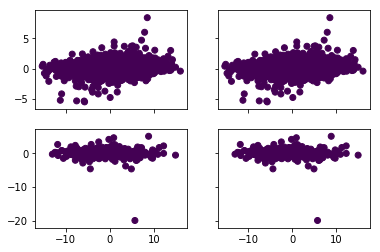

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 1cd69f91-a9b0-4e3f-891d-41e4a00b0ea7


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 1cd69f91-a9b0-4e3f-891d-41e4a00b0ea7


100% |██████████|[00:00<00:00]  104.08% /s] 


CrowdAI.Event.Job.INFO : (1cd69f91-a9b0-4e3f-891d-41e4a00b0ea7) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.411846270296 ; MSE : 59.7887571335
CrowdAI.Event.Job.COMPLETE : 1cd69f91-a9b0-4e3f-891d-41e4a00b0ea7	   🍺 


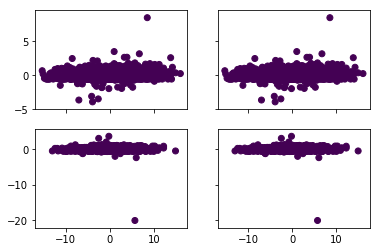

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 5c8eac1f-2843-416c-9ff1-650f07c4e808


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 5c8eac1f-2843-416c-9ff1-650f07c4e808


100% |██████████|[00:00<00:00]  102.69% /s] 


CrowdAI.Event.Job.INFO : (5c8eac1f-2843-416c-9ff1-650f07c4e808) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.424921974922 ; MSE : 58.4595466078
CrowdAI.Event.Job.COMPLETE : 5c8eac1f-2843-416c-9ff1-650f07c4e808	   🍺 


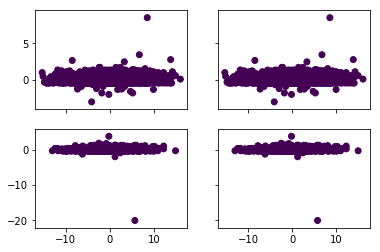

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : b28af7ca-b02a-4559-90c5-f9f55e6e5b33


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : b28af7ca-b02a-4559-90c5-f9f55e6e5b33


100% |██████████|[00:00<00:00]  104.35% /s] 


CrowdAI.Event.Job.INFO : (b28af7ca-b02a-4559-90c5-f9f55e6e5b33) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.424024723401 ; MSE : 58.5507566955
CrowdAI.Event.Job.COMPLETE : b28af7ca-b02a-4559-90c5-f9f55e6e5b33	   🍺 


In [376]:
lm_tz_f_res = topsnp_model(m=linear_model.LinearRegression(),X=X.loc[tz_f_idx,],y=y_residual,df_test=df_test,val_idx=tz_val_idx,residual=True)

In [348]:
lm_tz_f_res[0]

{7726: (1.0, -0.9623036136539065),
 5000: (1.0, -1.6218816189869099),
 2000: (0.9162506657740325, -4.607679346429234e+20),
 1000: (0.4677924364013135, -1.334793197765699e+22),
 500: (0.24155699300094732, -9.3486778145369e+20),
 200: (0.10858687258171984, -4.2373254841096387e+21),
 100: (0.04201527286441442, -0.0543317424730152),
 50: (0.03082678860116406, -0.026031303541691697),
 20: (0.012430273995367336, 0.0005834555686271559),
 10: (0.010633354396903938, 0.0038130173126311724)}

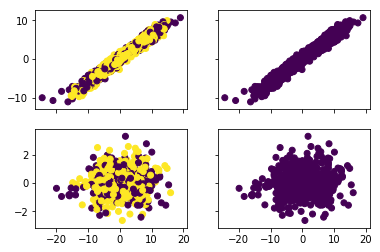

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d7429554-5fa3-4fa4-b093-38dfe7350601


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d7429554-5fa3-4fa4-b093-38dfe7350601


100% |██████████|[00:00<00:00]  107.64% /s] 


CrowdAI.Event.Job.INFO : (d7429554-5fa3-4fa4-b093-38dfe7350601) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.432892985965 ; MSE : 57.6492536193
CrowdAI.Event.Job.COMPLETE : d7429554-5fa3-4fa4-b093-38dfe7350601	   🍺 


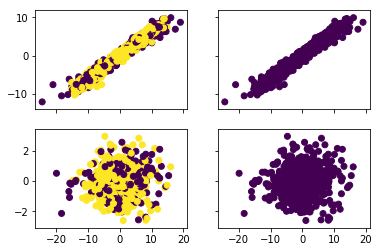

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 451d2e28-c586-4685-a594-b10a213defa7


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 451d2e28-c586-4685-a594-b10a213defa7


100% |██████████|[00:00<00:00]  108.35% /s] 


CrowdAI.Event.Job.INFO : (451d2e28-c586-4685-a594-b10a213defa7) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.412347596304 ; MSE : 59.7377948469
CrowdAI.Event.Job.COMPLETE : 451d2e28-c586-4685-a594-b10a213defa7	   🍺 


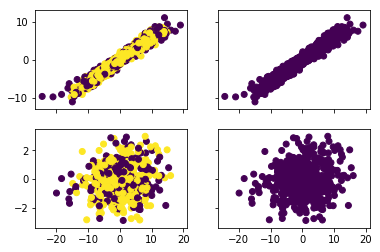

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 2f73816f-990e-4f4b-aba1-16202e0c1de0


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 2f73816f-990e-4f4b-aba1-16202e0c1de0


100% |██████████|[00:00<00:00]  105.85% /s] 


CrowdAI.Event.Job.INFO : (2f73816f-990e-4f4b-aba1-16202e0c1de0) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.409860768122 ; MSE : 59.9905933223
CrowdAI.Event.Job.COMPLETE : 2f73816f-990e-4f4b-aba1-16202e0c1de0	   🍺 


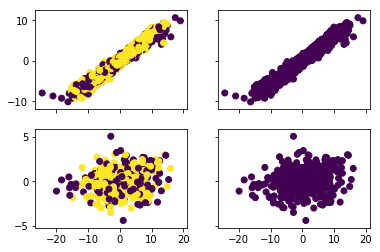

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 302a2421-a98a-4226-ad5a-39976ab81212


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 302a2421-a98a-4226-ad5a-39976ab81212


100% |██████████|[00:00<00:00]  108.16% /s] 


CrowdAI.Event.Job.INFO : (302a2421-a98a-4226-ad5a-39976ab81212) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.422188120428 ; MSE : 58.7374565388
CrowdAI.Event.Job.COMPLETE : 302a2421-a98a-4226-ad5a-39976ab81212	   🍺 


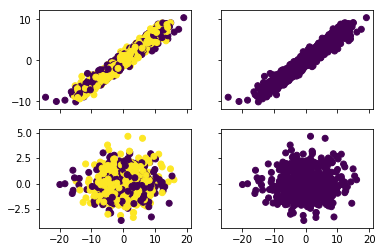

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 43cfee4a-5837-43ec-8a67-807485b9e41c


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 43cfee4a-5837-43ec-8a67-807485b9e41c


100% |██████████|[00:00<00:00]  107.44% /s] 


CrowdAI.Event.Job.INFO : (43cfee4a-5837-43ec-8a67-807485b9e41c) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.406299755644 ; MSE : 60.3525879837
CrowdAI.Event.Job.COMPLETE : 43cfee4a-5837-43ec-8a67-807485b9e41c	   🍺 


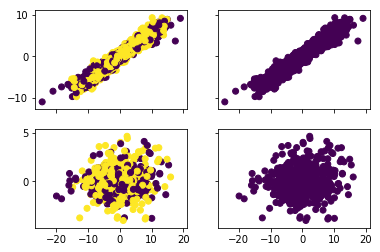

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 67d07807-1633-4696-8023-f836aa20869f


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 67d07807-1633-4696-8023-f836aa20869f


100% |██████████|[00:00<00:00]  102.84% /s] 


CrowdAI.Event.Job.INFO : (67d07807-1633-4696-8023-f836aa20869f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.410140400131 ; MSE : 59.9621673354
CrowdAI.Event.Job.COMPLETE : 67d07807-1633-4696-8023-f836aa20869f	   🍺 


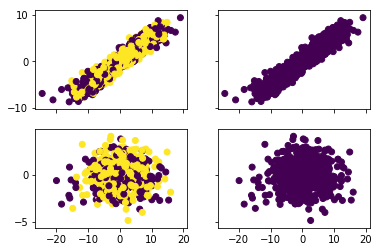

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 053b5e4b-1f20-42c7-bf5a-c2f9c7895edd


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 053b5e4b-1f20-42c7-bf5a-c2f9c7895edd


100% |██████████|[00:00<00:00]  107.97% /s] 


CrowdAI.Event.Job.INFO : (053b5e4b-1f20-42c7-bf5a-c2f9c7895edd) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.403035078204 ; MSE : 60.6844587119
CrowdAI.Event.Job.COMPLETE : 053b5e4b-1f20-42c7-bf5a-c2f9c7895edd	   🍺 


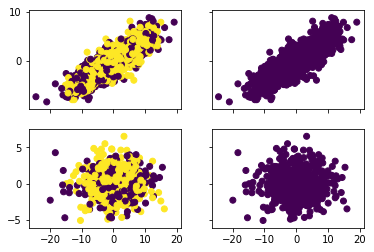

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bc3a149c-6aaf-4d01-987e-7cdff9c8728b


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bc3a149c-6aaf-4d01-987e-7cdff9c8728b


100% |██████████|[00:00<00:00]  107.85% /s] 


CrowdAI.Event.Job.INFO : (bc3a149c-6aaf-4d01-987e-7cdff9c8728b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.384640300249 ; MSE : 62.5543795441
CrowdAI.Event.Job.COMPLETE : bc3a149c-6aaf-4d01-987e-7cdff9c8728b	   🍺 


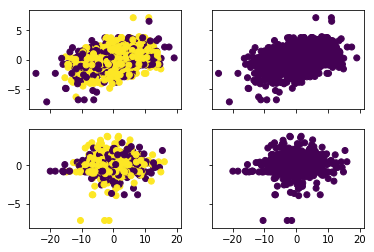

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : a9ab2673-cc56-461a-b514-caeff8359579


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : a9ab2673-cc56-461a-b514-caeff8359579


100% |██████████|[00:00<00:00]  109.13% /s] 


CrowdAI.Event.Job.INFO : (a9ab2673-cc56-461a-b514-caeff8359579) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.409777682224 ; MSE : 59.9990394179
CrowdAI.Event.Job.COMPLETE : a9ab2673-cc56-461a-b514-caeff8359579	   🍺 


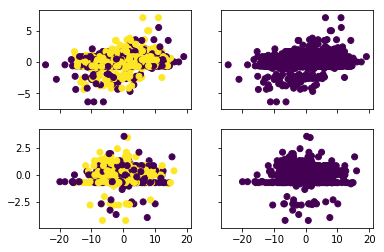

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 8323151f-a3ea-4078-b7c2-7c10c111b2ac


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 8323151f-a3ea-4078-b7c2-7c10c111b2ac


100% |██████████|[00:00<00:00]  105.46% /s] 


CrowdAI.Event.Job.INFO : (8323151f-a3ea-4078-b7c2-7c10c111b2ac) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.42947806525 ; MSE : 57.996397325
CrowdAI.Event.Job.COMPLETE : 8323151f-a3ea-4078-b7c2-7c10c111b2ac	   🍺 


In [349]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
rf_tz_res = topsnp_model(m=m,X=X.iloc[0:2747,],y=y_residual,df_test=df_test,val_idx=tz_val_idx,residual=True)

## 3.2 Random Forest with tz data

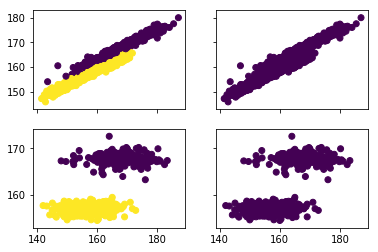

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Connection.CONNECTED
CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ed681d64-176b-4d89-b3d4-96fe5f8c11a3


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ed681d64-176b-4d89-b3d4-96fe5f8c11a3


100% |██████████|[00:00<00:00]  102.58% /s] 


CrowdAI.Event.Job.INFO : (ed681d64-176b-4d89-b3d4-96fe5f8c11a3) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.651270633356 ; MSE : 167.85988743
CrowdAI.Event.Job.COMPLETE : ed681d64-176b-4d89-b3d4-96fe5f8c11a3	   🍺 


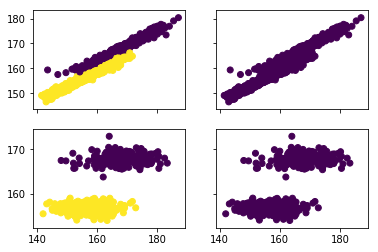

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : c0625866-12fe-4d90-8552-a216fbe4d1f6


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : c0625866-12fe-4d90-8552-a216fbe4d1f6


100% |██████████|[00:00<00:00]  106.41% /s] 


CrowdAI.Event.Job.INFO : (c0625866-12fe-4d90-8552-a216fbe4d1f6) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.594930950597 ; MSE : 162.132677961
CrowdAI.Event.Job.COMPLETE : c0625866-12fe-4d90-8552-a216fbe4d1f6	   🍺 


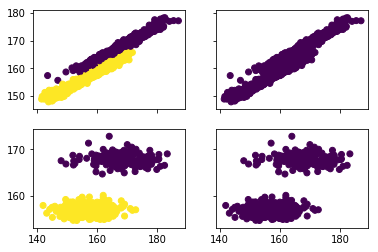

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 8c83df14-c48c-4ca1-983b-8d1e26b6152f


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 8c83df14-c48c-4ca1-983b-8d1e26b6152f


100% |██████████|[00:00<00:00]  106.68% /s] 


CrowdAI.Event.Job.INFO : (8c83df14-c48c-4ca1-983b-8d1e26b6152f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.647314761775 ; MSE : 167.457753373
CrowdAI.Event.Job.COMPLETE : 8c83df14-c48c-4ca1-983b-8d1e26b6152f	   🍺 


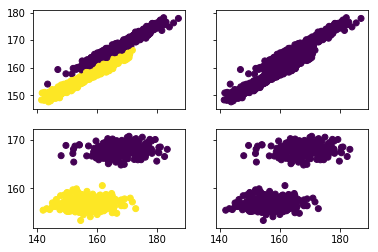

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 2cc8f5c9-d41a-4c99-a35b-af635f5b1169


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 2cc8f5c9-d41a-4c99-a35b-af635f5b1169


100% |██████████|[00:00<00:00]  100.23% /s] 


CrowdAI.Event.Job.INFO : (2cc8f5c9-d41a-4c99-a35b-af635f5b1169) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.722000381958 ; MSE : 175.04991879
CrowdAI.Event.Job.COMPLETE : 2cc8f5c9-d41a-4c99-a35b-af635f5b1169	   🍺 


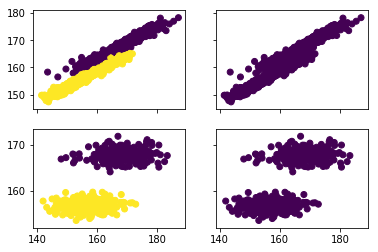

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 9f2b7a36-ceea-4a74-a55d-4ae751a1ea23


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 9f2b7a36-ceea-4a74-a55d-4ae751a1ea23


100% |██████████|[00:00<00:00]  107.66% /s] 


CrowdAI.Event.Job.INFO : (9f2b7a36-ceea-4a74-a55d-4ae751a1ea23) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.638326281373 ; MSE : 166.544029555
CrowdAI.Event.Job.COMPLETE : 9f2b7a36-ceea-4a74-a55d-4ae751a1ea23	   🍺 


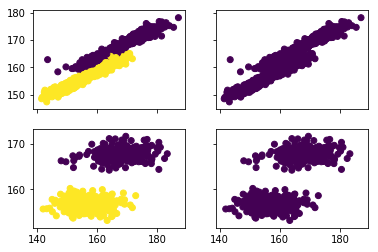

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ef070551-e21f-4c8e-b740-fe614c91c601


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ef070551-e21f-4c8e-b740-fe614c91c601


100% |██████████|[00:00<00:00]  106.90% /s] 


CrowdAI.Event.Job.INFO : (ef070551-e21f-4c8e-b740-fe614c91c601) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.6843958048 ; MSE : 171.227226155
CrowdAI.Event.Job.COMPLETE : ef070551-e21f-4c8e-b740-fe614c91c601	   🍺 


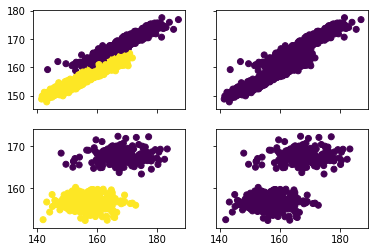

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 4cac4743-22c9-40fc-8487-df11dbe8729f


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 4cac4743-22c9-40fc-8487-df11dbe8729f


100% |██████████|[00:00<00:00]  105.35% /s] 


CrowdAI.Event.Job.INFO : (4cac4743-22c9-40fc-8487-df11dbe8729f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.640375315109 ; MSE : 166.752324043
CrowdAI.Event.Job.COMPLETE : 4cac4743-22c9-40fc-8487-df11dbe8729f	   🍺 


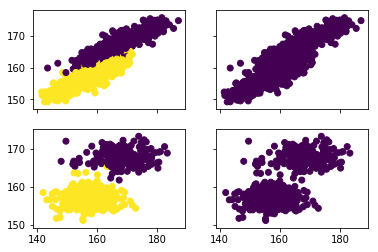

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 73eec3a1-cebb-4a07-a26d-c6084ca3f511


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 73eec3a1-cebb-4a07-a26d-c6084ca3f511


100% |██████████|[00:00<00:00]  106.98% /s] 


CrowdAI.Event.Job.INFO : (73eec3a1-cebb-4a07-a26d-c6084ca3f511) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.614963992381 ; MSE : 164.169136475
CrowdAI.Event.Job.COMPLETE : 73eec3a1-cebb-4a07-a26d-c6084ca3f511	   🍺 


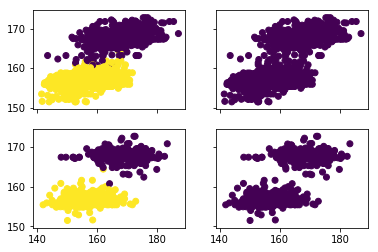

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : f4d6a187-423c-4780-b63e-4c3140e50a1e


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : f4d6a187-423c-4780-b63e-4c3140e50a1e


100% |██████████|[00:00<00:00]  101.33% /s] 


CrowdAI.Event.Job.INFO : (f4d6a187-423c-4780-b63e-4c3140e50a1e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.669432310805 ; MSE : 169.706112434
CrowdAI.Event.Job.COMPLETE : f4d6a187-423c-4780-b63e-4c3140e50a1e	   🍺 


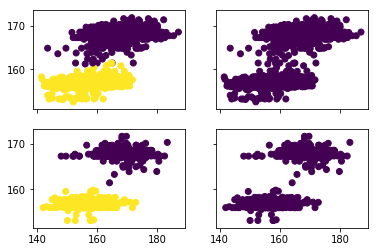

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 7bb6da57-22e9-4177-8c93-7178db77d5c5


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 7bb6da57-22e9-4177-8c93-7178db77d5c5


100% |██████████|[00:00<00:00]  102.28% /s] 


CrowdAI.Event.Job.INFO : (7bb6da57-22e9-4177-8c93-7178db77d5c5) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.620139691473 ; MSE : 164.695272076
CrowdAI.Event.Job.COMPLETE : 7bb6da57-22e9-4177-8c93-7178db77d5c5	   🍺 


In [351]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
rf_tz = topsnp_model(m=m,X=X.iloc[0:2747,],y=y.iloc[0:2747,],df_test=df_test,val_idx=tz_val_idx)

In [352]:
rf_tz[0]

{7726: (0.9130616592492592, 0.475471828003499),
 5000: (0.9124809436304251, 0.48488068959179076),
 2000: (0.9101848972693694, 0.4690624900349124),
 1000: (0.9074244771162757, 0.4804392117072688),
 500: (0.9046918603111446, 0.48294912007481755),
 200: (0.8890371840464301, 0.47752630360984333),
 100: (0.873026759878836, 0.4557303060039193),
 50: (0.8056156815810166, 0.43347376313616215),
 20: (0.5343511399253469, 0.4667554512909726),
 10: (0.49938197344667734, 0.4772599076587596)}

In [174]:
#Load training data
x_train = X.iloc[2747:3530,]
y_train = y.iloc[2747:3530,]
x_test = df_test

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : c91fd1c9-9dcc-440d-9959-158b793f250a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : c91fd1c9-9dcc-440d-9959-158b793f250a


100% |██████████|[00:01<00:00]  100.08% /s] 


CrowdAI.Event.Job.INFO : (c91fd1c9-9dcc-440d-9959-158b793f250a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.2968362511e+19 ; MSE : 2.3348484904e+21
CrowdAI.Event.Job.COMPLETE : c91fd1c9-9dcc-440d-9959-158b793f250a	   🍺 


In [175]:
#Load training data
x_train = X.iloc[2747:3530,]
y_train = y.iloc[2747:3530,]
x_test = df_test

x_train = x_train[['gender','nationality']]
y_train = y_train
x_test = df_test[['gender','nationality']]

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ff9496a5-4347-4bca-be34-8213cc3ab7ce


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ff9496a5-4347-4bca-be34-8213cc3ab7ce


100% |██████████|[00:00<00:00]  103.52% /s] 


CrowdAI.Event.Job.INFO : (ff9496a5-4347-4bca-be34-8213cc3ab7ce) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.420750671304 ; MSE : 58.8835804044
CrowdAI.Event.Job.COMPLETE : ff9496a5-4347-4bca-be34-8213cc3ab7ce	   🍺 


## Sample seperation

3530 2647


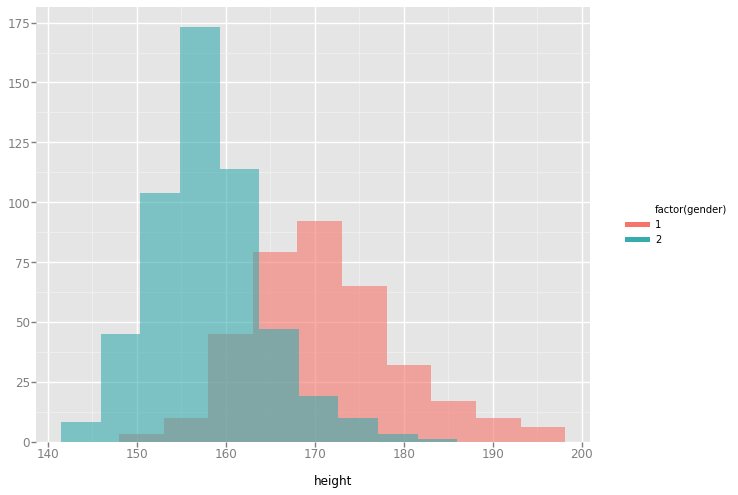

<ggplot: (8760316177135)>

In [105]:
samp_size=len(all_meta)
train_ratio = 0.75
#train_ratio = 0.9
train_size = int(samp_size * train_ratio)

import random
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
ggplot( aes(x='height',fill='factor(gender)'),data=all_meta.loc[val_idx]) +\
    geom_histogram(alpha=0.6)

## Random Forest

In [156]:
from sklearn.ensemble import RandomForestRegressor

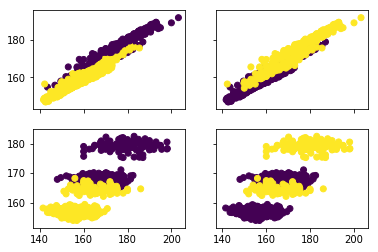

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:57:50<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 0ac21f73-e2e2-4756-9da0-eee9f5390649



          
  0% |          |[16:57:50<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 0ac21f73-e2e2-4756-9da0-eee9f5390649



          
  0% |          |[16:57:51<?]  ?% /s] 
100% |██████████|[00:01<00:00]  98.17% /s] 
          
  0% |          |[16:57:51<?]  ?% /s]  /s] 


CrowdAI.Event.Job.INFO : (0ac21f73-e2e2-4756-9da0-eee9f5390649) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.389142137054 ; MSE : 62.0967454022
CrowdAI.Event.Job.COMPLETE : 0ac21f73-e2e2-4756-9da0-eee9f5390649	   🍺 


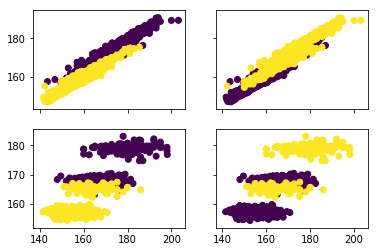

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:57:59<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : f784e2aa-25ce-46ba-8207-5913cbd8d857



          
  0% |          |[16:57:59<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : f784e2aa-25ce-46ba-8207-5913cbd8d857



          
  0% |          |[16:58:00<?]  ?% /s] 
100% |██████████|[00:01<00:00]  92.20% /s] 
          
  0% |          |[16:58:00<?]  ?% /s]  /s] 


CrowdAI.Event.Job.INFO : (f784e2aa-25ce-46ba-8207-5913cbd8d857) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.423537702887 ; MSE : 58.6002647574
CrowdAI.Event.Job.COMPLETE : f784e2aa-25ce-46ba-8207-5913cbd8d857	   🍺 


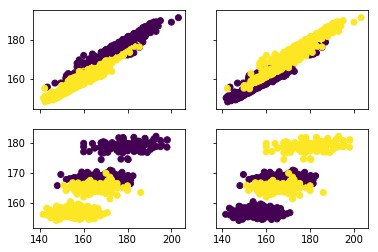

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:58:06<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : dd65ae19-d11d-4158-be54-593b03b96ec2



          
  0% |          |[16:58:06<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : dd65ae19-d11d-4158-be54-593b03b96ec2



          
  0% |          |[16:58:06<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.27% /s] 
          
  0% |          |[16:58:06<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (dd65ae19-d11d-4158-be54-593b03b96ec2) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.411759929011 ; MSE : 59.7975341553
CrowdAI.Event.Job.COMPLETE : dd65ae19-d11d-4158-be54-593b03b96ec2	   🍺 


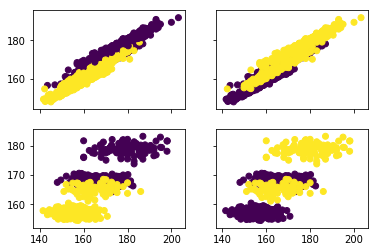

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:58:11<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : a59bb36b-09c3-4fac-b4b7-1bcaa7351eff



          
  0% |          |[16:58:12<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : a59bb36b-09c3-4fac-b4b7-1bcaa7351eff



          
  0% |          |[16:58:12<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.36% /s] 
          
  0% |          |[16:58:12<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (a59bb36b-09c3-4fac-b4b7-1bcaa7351eff) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.438238758986 ; MSE : 57.1058291561
CrowdAI.Event.Job.COMPLETE : a59bb36b-09c3-4fac-b4b7-1bcaa7351eff	   🍺 


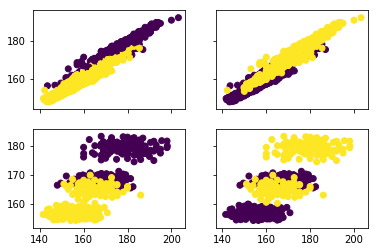

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:58:16<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 33dbfcce-f301-42f4-82fe-bc03d91e2522



          
  0% |          |[16:58:17<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 33dbfcce-f301-42f4-82fe-bc03d91e2522



          
  0% |          |[16:58:17<?]  ?% /s] 
100% |██████████|[00:00<00:00]  102.15% /s] 
          
  0% |          |[16:58:17<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (33dbfcce-f301-42f4-82fe-bc03d91e2522) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.417158263699 ; MSE : 59.2487665368
CrowdAI.Event.Job.COMPLETE : 33dbfcce-f301-42f4-82fe-bc03d91e2522	   🍺 


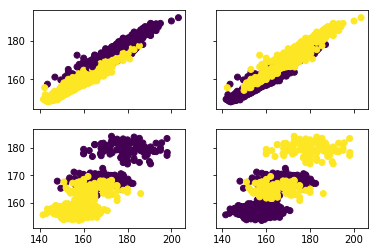

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:58:21<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3a8518a5-8bec-489b-90c5-4b032c4b7979



          
  0% |          |[16:58:21<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3a8518a5-8bec-489b-90c5-4b032c4b7979



          
  0% |          |[16:58:22<?]  ?% /s] 
100% |██████████|[00:00<00:00]  106.18% /s] 
          
  0% |          |[16:58:22<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (3a8518a5-8bec-489b-90c5-4b032c4b7979) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.378273141194 ; MSE : 63.2016329867
CrowdAI.Event.Job.COMPLETE : 3a8518a5-8bec-489b-90c5-4b032c4b7979	   🍺 


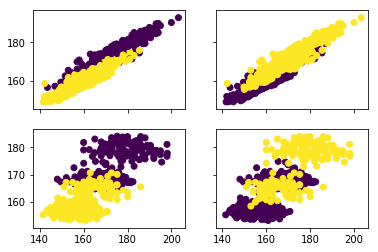

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:58:26<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : e0b6d745-159f-4b56-b614-2f97f6236de9



          
  0% |          |[16:58:26<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : e0b6d745-159f-4b56-b614-2f97f6236de9



          
  0% |          |[16:58:27<?]  ?% /s] 
100% |██████████|[00:00<00:00]  108.48% /s] 
          
  0% |          |[16:58:27<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (e0b6d745-159f-4b56-b614-2f97f6236de9) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.384790681165 ; MSE : 62.5390925747
CrowdAI.Event.Job.COMPLETE : e0b6d745-159f-4b56-b614-2f97f6236de9	   🍺 


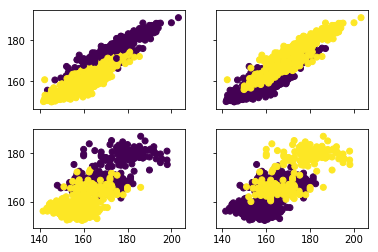

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:58:31<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 3200c20d-52eb-4530-8fde-c1e266665922



          
  0% |          |[16:58:31<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 3200c20d-52eb-4530-8fde-c1e266665922



          
  0% |          |[16:58:32<?]  ?% /s] 
100% |██████████|[00:00<00:00]  101.72% /s] 
          
  0% |          |[16:58:32<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (3200c20d-52eb-4530-8fde-c1e266665922) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.364125365811 ; MSE : 64.6398248465
CrowdAI.Event.Job.COMPLETE : 3200c20d-52eb-4530-8fde-c1e266665922	   🍺 


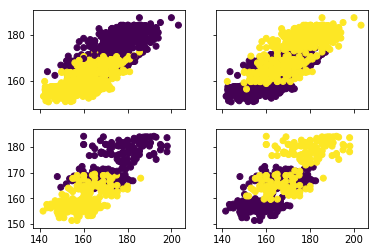

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:58:36<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : f945ffd3-1fd6-410f-a84f-80b54c707149



          
  0% |          |[16:58:36<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : f945ffd3-1fd6-410f-a84f-80b54c707149



          
  0% |          |[16:58:36<?]  ?% /s] 
100% |██████████|[00:00<00:00]  111.03% /s] 
          
  0% |          |[16:58:36<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (f945ffd3-1fd6-410f-a84f-80b54c707149) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.358270196877 ; MSE : 65.2350319424
CrowdAI.Event.Job.COMPLETE : f945ffd3-1fd6-410f-a84f-80b54c707149	   🍺 


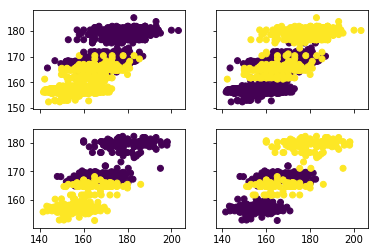

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:58:40<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 845069eb-e87e-433d-8f15-f09bad634ed0



          
  0% |          |[16:58:40<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 845069eb-e87e-433d-8f15-f09bad634ed0



          
  0% |          |[16:58:41<?]  ?% /s] 
100% |██████████|[00:00<00:00]  104.41% /s] 
          
  0% |          |[16:58:41<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (845069eb-e87e-433d-8f15-f09bad634ed0) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.395113315211 ; MSE : 61.4897453908
CrowdAI.Event.Job.COMPLETE : 845069eb-e87e-433d-8f15-f09bad634ed0	   🍺 


In [157]:
score_list={}
submit={}
for n in [7726, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10]:
    var_idx = list(range(n))+list([7726,7727])
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.iloc[:,var_idx].values, np.array(y))
    x_test = df_test.iloc[:,var_idx].values
  
    rf = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                                n_jobs=-1, oob_score=True)
    rf.fit(trn, y_trn)
    

    preds = np.clip(rf.predict(trn),145,195)
    preds1 = np.clip(rf.predict(val),145,195)

    score_list[n]=(rf.score(trn, y_trn), rf.score(val, y_val))

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    ax1.scatter(y_trn,preds,c=trn[:,-2], marker='o')
    ax2.scatter(y_trn,preds,c=trn[:,-1], marker='o')
    ax3.scatter(y_val,preds1,c=val[:,-2], marker='o')
    ax4.scatter(y_val,preds1,c=val[:,-1], marker='o')
    plt.show()

    heights = np.clip(rf.predict(x_test),145,195).tolist()
    # Create the challenge object by authentication with crowdAI with your API_KEY
    challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
    submit[n]=challenge.submit(heights)
    challenge.disconnect()


In [158]:
score_list

{7726: (0.9357013211874846, 0.6120117755820358),
 5000: (0.934008633965682, 0.6161503153934631),
 2000: (0.9314624002551604, 0.6216246013829978),
 1000: (0.9309064804833995, 0.60967901803535),
 500: (0.9308250776915717, 0.6133699422722685),
 200: (0.9222609116360915, 0.5986320858503165),
 100: (0.9095978389751086, 0.5922694674417623),
 50: (0.8676503612512116, 0.5853376147638147),
 20: (0.6717117403193738, 0.6065853546253821),
 10: (0.6331155541696407, 0.6133322345341987)}

In [3]:
preds = m.predict(val)

NameError: name 'm' is not defined

In [285]:
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_

(0.8439407662079724, 0.11804699118137751, 0.0804589756030738)

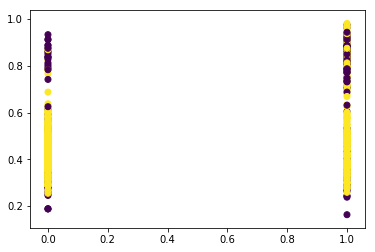

In [286]:
plt.scatter(y_val,preds,c=list(val[:,7726]), marker='o')

In [2]:
heights = m.predict(df_test).tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

NameError: name 'm' is not defined

## NN1

In [1]:
cat_vars = ['gender','nationality']
contin_vars = X.columns[:-2]

NameError: name 'X' is not defined

In [194]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, X, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test,is_reg=False)

In [195]:
cat_sz = [(c, 3) for c in cat_vars]
cat_sz

[('gender', 3), ('nationality', 3)]

In [196]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(3, 2), (3, 2)]

In [197]:
y_range = (130,210)

In [198]:
#m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
#                   0, 1, [256,128,64], [0.3,0.5,0.3], y_range=y_range)

In [213]:
m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                   0, 1, [128,64,16], [0,0.1,0.1])

In [214]:
lr = 1e-3

In [227]:
m.lr_find()

 43%|████▎     | 9/21 [00:00<00:00, 87.59it/s, loss=46.3]


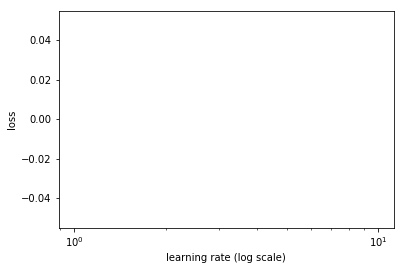

In [228]:
m.sched.plot()

In [229]:
m.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      55.250753  62.687112 
    1      58.415913  64.20576                             
    2      56.39197   62.964787                          



[array([62.96479])]

In [230]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      56.733091  62.744966 
    1      49.164127  62.002885                            
    2      44.179577  61.256397                          
    3      42.012801  60.872404                            
    4      39.967664  60.322566                          
    5      43.533669  60.629964                            
    6      42.154946  58.021469                          
    7      41.29138   57.008608                          
    8      40.034128  56.676835                          
    9      40.916238  60.169139                            



[array([60.16914])]

In [983]:
m.save('nn_model1') #R2=0.355

 24%|██▍       | 12/50 [00:00<00:00, 119.82it/s, loss=43.2]

epoch      trn_loss   val_loss                             
    0      80.888028  151.194055



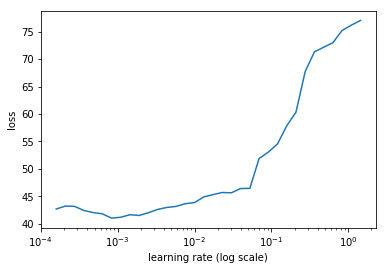

In [984]:
m.lr_find()
m.sched.plot()

In [985]:
m.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss                             
    0      50.995664  42.544632 
    1      43.480691  41.338056                            
    2      42.126355  41.464497                            



[array([41.4645])]

In [1026]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      57.78584   49.578513 
    1      53.775634  46.085355                            
    2      51.614049  43.825487                            
    3      50.302809  40.732563                            
    4      49.565065  43.737697                           
    5      47.954103  40.983987                            
    6      47.264173  38.763312                          
    7      46.305101  38.572067                            
    8      45.49319   38.968085                            
    9      46.022123  39.092998                            



[array([39.093])]

In [987]:
m.save('nn_model2') #R2=0.436

In [9]:
m.load('nn_model2')

NameError: name 'm' is not defined

In [231]:
# Predict the heights for the test set
heights = m.predict(True)
heights=heights.reshape(137)
heights = heights.tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : adf40834-afd7-4b4d-bb1d-a0116c14b777


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : adf40834-afd7-4b4d-bb1d-a0116c14b777


100% |██████████|[00:00<00:00]  109.49% /s] 


CrowdAI.Event.Job.INFO : (adf40834-afd7-4b4d-bb1d-a0116c14b777) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.073840333075 ; MSE : 94.1487447856
CrowdAI.Event.Job.COMPLETE : adf40834-afd7-4b4d-bb1d-a0116c14b777	   🍺 


## NN2

In [972]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(y)
y_range = (140,200)

In [317]:
maf=pd.read_csv('../predict_height/lib/maf.csv',index_col=0)

In [321]:
sum([x in maf.index for x in all_bim.snp])

628

In [792]:
# Instantiate a linear model
x_train=X
y_train=y
x_test=df_test
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)

In [793]:
#Convert heights from np.array to a list (to ensure it is JSON serializable)
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")

heights = heights.tolist()
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 
100% |██████████|[00:00<00:00]  102.69% /s] 
          
  0% |          |[16:49<?]  ?% /s] .69% /s] 


CrowdAI.Event.Job.INFO : (bc1ef311-9598-4a6c-a9a2-cce75662d779) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.0365818509984 ; MSE : 105.373709981
CrowdAI.Event.Job.COMPLETE : bc1ef311-9598-4a6c-a9a2-cce75662d779	   🍺 


In [ ]:
import preprocess
import argparse
import models


def init_args():
    parser = argparse.ArgumentParser(description='Train and save models')
    parser.add_argument('train_datesets', help='Input csv file for training output from parse_inputs.py')
    parser.add_argument('-m', '--model', help='Train model, comma to separate', default='gbr')
    parser.add_argument('-d', '--model-dir', help='Model directory', default='models')
    parser.add_argument('-l', '--list-models', help='List available models', action='store_true')
    args = parser.parse_args()
    return args


def main():
    args = init_args()
    if args.list_models:
        print('\n'.join(models.get_model_names()))
        exit()
    m = args.model.split(',')
    dict_m = models.get_models(m)
    x, y = preprocess.load_data(args.train_datesets)
    for model_name in dict_m:
        model = dict_m[model_name]
        print('Training model %s' % model_name)
        model.fit(x, y)
        models.save_model(model, model_name, args.model_dir)
        print('Train finished, save to %s' % args.model_dir)

